# **Minor Project**
## Credit Card Fraud **Detection**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import itertools
import calendar
from scipy.stats import norm, skew
import random
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import resample # Correcting the imbalance discovered by using resample
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.metrics import accuracy_score, mean_absolute_error ,mean_squared_error, confusion_matrix, median_absolute_error,classification_report, f1_score,recall_score,precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import HalvingRandomSearchCV,RandomizedSearchCV
# Checking p-values and Variation Inflation Factor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Loading the Dataset

In [2]:

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [154]:
train = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv')
test = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv') 
train.head()
# test.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [155]:
train.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [156]:
# This prints the shape of dataset

print("fraudTrain.csv Shape : " , test.shape)
print("fraudTest.csv Shape : " , train.shape)

fraudTrain.csv Shape :  (1296675, 23)
fraudTest.csv Shape :  (1296675, 23)


## Data Cleaning

In [157]:
test.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [158]:
train.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [159]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [160]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

Converting dob, trans_date_trans_time column in both test & train to datetime data type and creating new 'trans_date' column -

In [161]:
train['trans_date_trans_time']=pd.to_datetime(train['trans_date_trans_time'])
train['trans_date']=train['trans_date_trans_time'].dt.strftime('%Y-%m-%d')
train['trans_date']=pd.to_datetime(train['trans_date'])
train['dob']=pd.to_datetime(train['dob'])

test['trans_date_trans_time']=pd.to_datetime(test['trans_date_trans_time'])
test['trans_date']=test['trans_date_trans_time'].dt.strftime('%Y-%m-%d')
test['trans_date']=pd.to_datetime(test['trans_date'])
test['dob']=pd.to_datetime(test['dob'])

In [162]:
test.trans_date.head(),test.dob.head(),train.trans_date.head(),train.dob.head()

(0   2019-01-01
 1   2019-01-01
 2   2019-01-01
 3   2019-01-01
 4   2019-01-01
 Name: trans_date, dtype: datetime64[ns],
 0   1988-03-09
 1   1978-06-21
 2   1962-01-19
 3   1967-01-12
 4   1986-03-28
 Name: dob, dtype: datetime64[ns],
 0   2019-01-01
 1   2019-01-01
 2   2019-01-01
 3   2019-01-01
 4   2019-01-01
 Name: trans_date, dtype: datetime64[ns],
 0   1988-03-09
 1   1978-06-21
 2   1962-01-19
 3   1967-01-12
 4   1986-03-28
 Name: dob, dtype: datetime64[ns])

In [163]:
train.drop("Unnamed: 0",axis=1,inplace=True)
test.drop("Unnamed: 0",axis=1,inplace=True)
train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_date
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019-01-01
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019-01-01
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,2019-01-01
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,2019-01-01
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,2019-01-01


**EDA, Feature Engineering**

Categorical Variable Analysis


In [164]:
total = pd.concat([test,train])
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2593350 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   cc_num                 int64         
 2   merchant               object        
 3   category               object        
 4   amt                    float64       
 5   first                  object        
 6   last                   object        
 7   gender                 object        
 8   street                 object        
 9   city                   object        
 10  state                  object        
 11  zip                    int64         
 12  lat                    float64       
 13  long                   float64       
 14  city_pop               int64         
 15  job                    object        
 16  dob                    datetime64[ns]
 17  trans_num              object        
 18  unix_time             

In [165]:
total["is_fraud_cat"]=total.is_fraud.apply(lambda x: "T" if x==1 else "F")
total["is_fraud_cat"].astype("object")

0          F
1          F
2          F
3          F
4          F
          ..
1296670    F
1296671    F
1296672    F
1296673    F
1296674    F
Name: is_fraud_cat, Length: 2593350, dtype: object

In [166]:
totalcat=total.select_dtypes(include=['object'])

In [167]:
total[totalcat.columns]


,merchant,category,first,last,gender,street,city,state,job,trans_num,is_fraud_cat
0,"fraud_Rippin, Kub and Mann",misc_net,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,"Psychologist, counselling",0b242abb623afc578575680df30655b9,F
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,Special educational needs teacher,1f76529f8574734946361c461b024d99,F
2,fraud_Lind-Buckridge,entertainment,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,Nature conservation officer,a1a22d70485983eac12b5b88dad1cf95,F
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,Patent attorney,6b849c168bdad6f867558c3793159a81,F
4,fraud_Keeling-Crist,misc_pos,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,Dance movement psychotherapist,a41d7549acf90789359a9aa5346dcb46,F
...,...,...,...,...,...,...,...,...,...,...,...
1296670,fraud_Reichel Inc,entertainment,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,UT,Geoscientist,440b587732da4dc1a6395aba5fb41669,F
1296671,fraud_Abernathy and Sons,food_dining,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,MD,"Production assistant, television",278000d2e0d2277d1de2f890067dcc0a,F
1296672,fraud_Stiedemann Ltd,food_dining,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,Naval architect,483f52fe67fabef353d552c1e662974c,F
1296673,"fraud_Reinger, Weissnat and Strosin",food_dining,Joseph,Murray,M,42933 Ryan Underpass,Manderson,SD,Volunteer coordinator,d667cdcbadaaed3da3f4020e83591c83,F


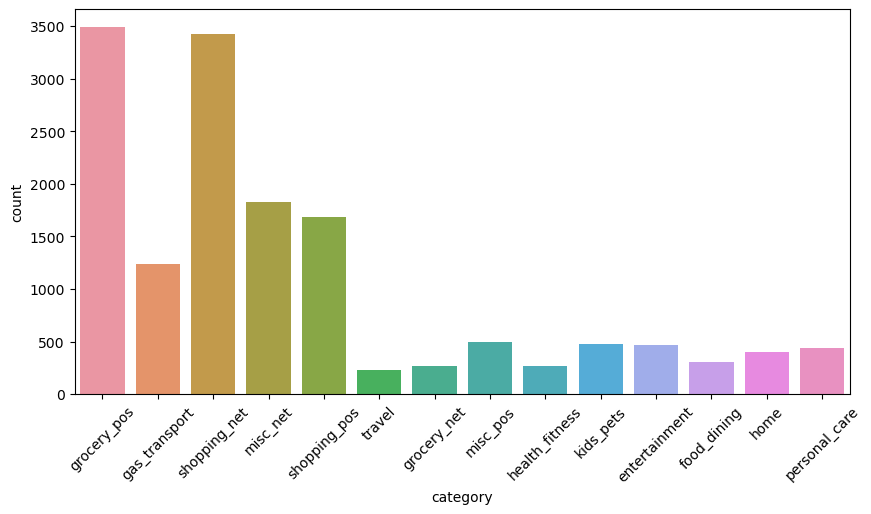

In [168]:
plt.figure(figsize=(10,5))
sns.countplot(x=total[total['is_fraud_cat']=="T"].category)
plt.xticks(rotation=45)
plt.show()


Most frauds occured in categories of shopping_net and grocery_pos


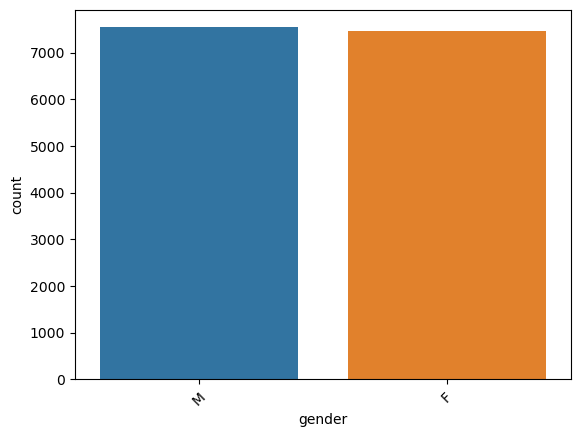

In [169]:
sns.countplot(x=total[total['is_fraud_cat']=="T"].gender)
plt.xticks(rotation=45)
plt.show()

Although more cases of fraud happened with female customers, the number is almost the same for both Males and Females

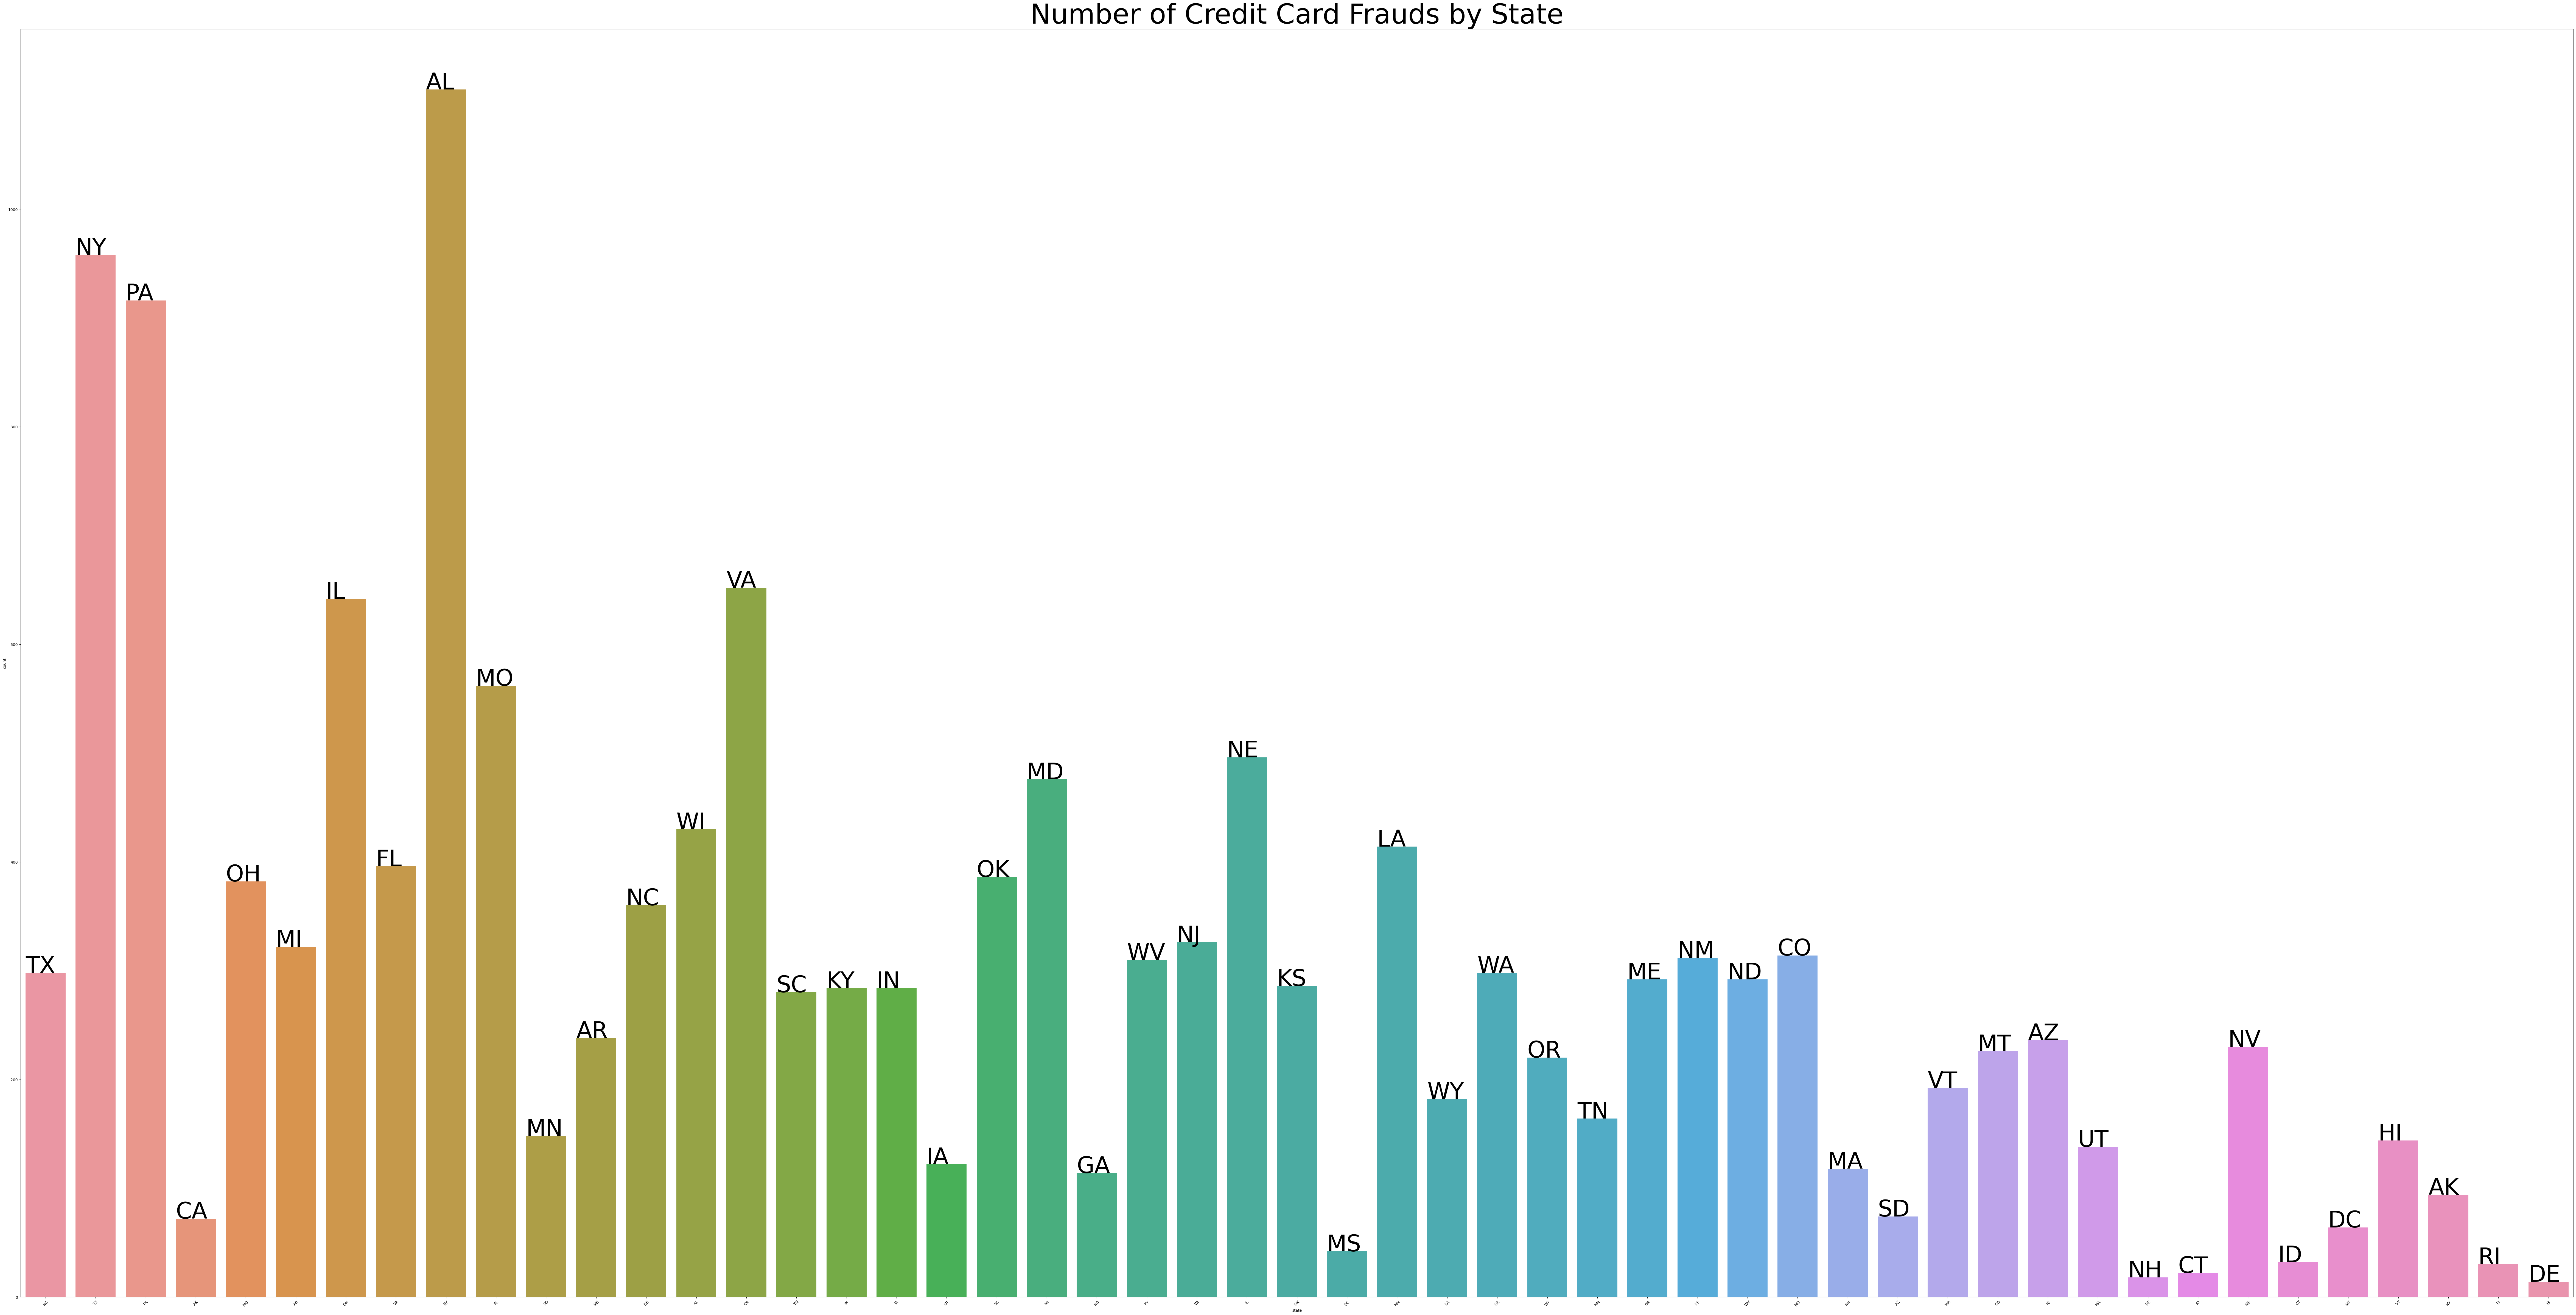

In [170]:
fig, ax = plt.subplots(figsize=(120,60))
plt.rcParams.update({'font.size': 60})
sns.countplot(x=total[total['is_fraud_cat']=="T"].state)
plt.xticks(rotation=45)
for p, label in zip(ax.patches, total["state"].value_counts().index):
    ax.annotate(label, (p.get_x(), p.get_height()+0.15))
plt.title("Number of Credit Card Frauds by State")
plt.show()

States OH, TX and LA report the most number of credit card frauds

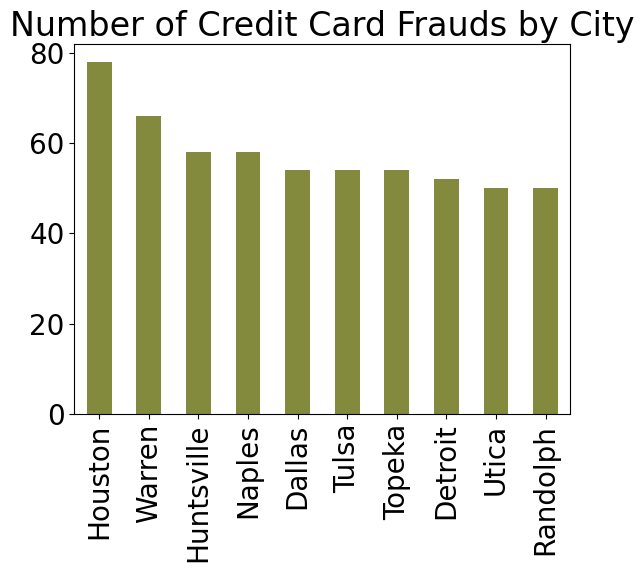

In [171]:
def randomcolor():
    r = random.random()
    b = random.random()
    g = random.random()
    rgb = [r,g,b]
    return rgb
plt.rcParams.update({'font.size': 20})
total[total['is_fraud_cat']=="T"]["city"].value_counts(sort=True,ascending=False).head(10).plot(kind="bar",color=randomcolor())
plt.title("Number of Credit Card Frauds by City")
plt.show()

Dallas,Houston and Birmingham report the most frauds city wise.

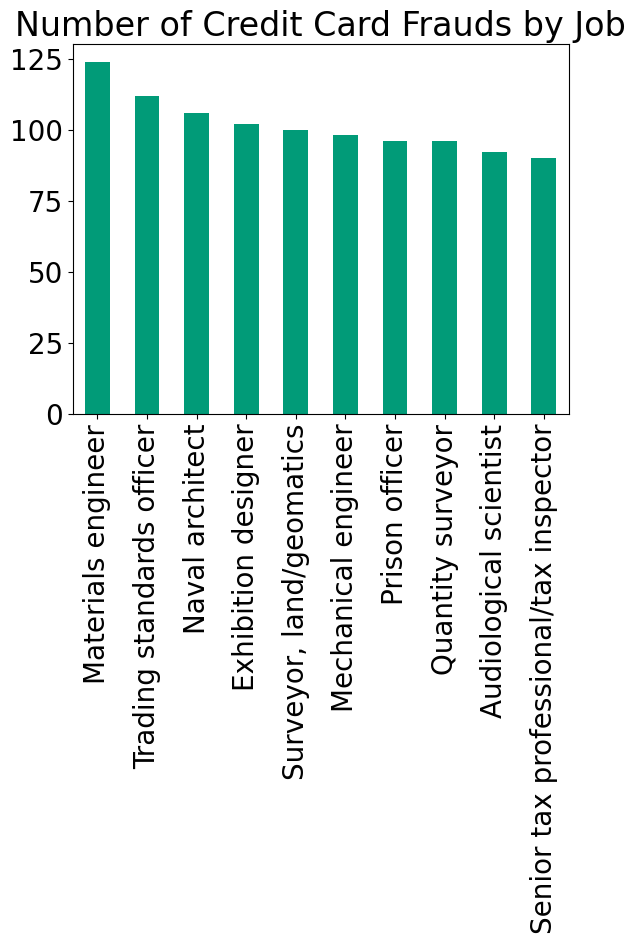

In [172]:
total[total['is_fraud_cat']=="T"]["job"].value_counts(sort=True,ascending=False).head(10).plot(kind="bar",color=randomcolor())
plt.title("Number of Credit Card Frauds by Job")
plt.show()


Most frauds occured in jobs of quantity surveyor followed by naval architect and materials engineer

**Numerical Variable Analysis**

checking the spread & skewness of all numerical variables

In [173]:
del total['is_fraud_cat']



In [174]:
#finding numerical columns
testnum= test.select_dtypes(include=np.number)
test[testnum.columns]


,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
0,2703186189652095,4.97,28654,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0
1,630423337322,107.23,99160,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0
2,38859492057661,220.11,83252,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0
3,3534093764340240,45.00,59632,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0
4,375534208663984,41.96,24433,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...
1296670,30263540414123,15.56,84735,37.7175,-112.4777,258,1371816728,36.841266,-111.690765,0
1296671,6011149206456997,51.70,21790,39.2667,-77.5101,100,1371816739,38.906881,-78.246528,0
1296672,3514865930894695,105.93,88325,32.9396,-105.8189,899,1371816752,33.619513,-105.130529,0
1296673,2720012583106919,74.90,57756,43.3526,-102.5411,1126,1371816816,42.788940,-103.241160,0


In [175]:
total.isnull().sum()


trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
trans_date               0
dtype: int64

In [176]:
total[testnum.columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2593350 entries, 0 to 1296674
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   cc_num      int64  
 1   amt         float64
 2   zip         int64  
 3   lat         float64
 4   long        float64
 5   city_pop    int64  
 6   unix_time   int64  
 7   merch_lat   float64
 8   merch_long  float64
 9   is_fraud    int64  
dtypes: float64(5), int64(5)
memory usage: 217.6 MB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until


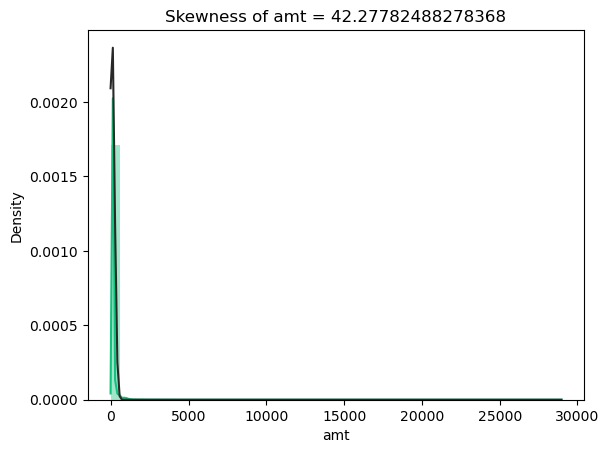

In [177]:
plt.rcParams.update({'font.size': 10})
skewness = str(skew(total['amt']))
sns.distplot(total['amt'],fit = norm,color = randomcolor())
plt.title("Skewness of amt"+" = "+skewness)
plt.show()

Most transactions are limited within a very small bracket, although transactions of large sums are very much present, which are likely to be fraud transactions.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


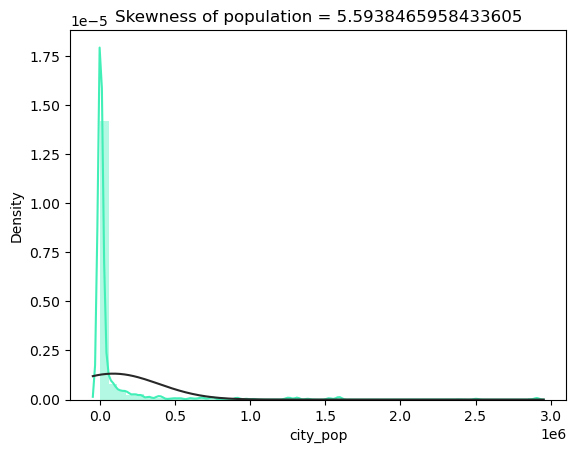

In [178]:
skewness = str(skew(total['city_pop']))
sns.distplot(total['city_pop'],fit = norm,color = randomcolor())
plt.title("Skewness of population"+" = "+skewness)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


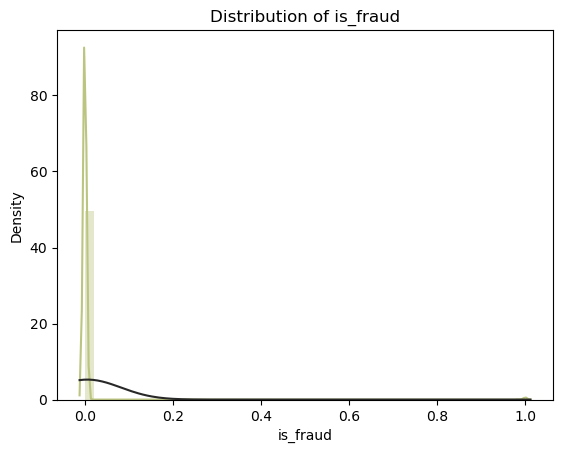

In [179]:
sns.distplot(total['is_fraud'],fit = norm,color = randomcolor())
plt.title("Distribution of is_fraud")
plt.show()


Certain numerical columns are not needed for modeling and hence can be removed.

Moreover, a lot of the data is highly skewed.

one insight is that proportion of non fraud transactions are much much larger than fraud transactions so we are looking at an imbalanced dataset.

In [180]:
total.drop(['cc_num','merchant','first','last','street','zip','trans_num','unix_time'],axis=1,inplace=True)
total.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2593350 entries, 0 to 1296674
Data columns (total 15 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   category               object        
 2   amt                    float64       
 3   gender                 object        
 4   city                   object        
 5   state                  object        
 6   lat                    float64       
 7   long                   float64       
 8   city_pop               int64         
 9   job                    object        
 10  dob                    datetime64[ns]
 11  merch_lat              float64       
 12  merch_long             float64       
 13  is_fraud               int64         
 14  trans_date             datetime64[ns]
dtypes: datetime64[ns](3), float64(5), int64(2), object(5)
memory usage: 316.6+ MB


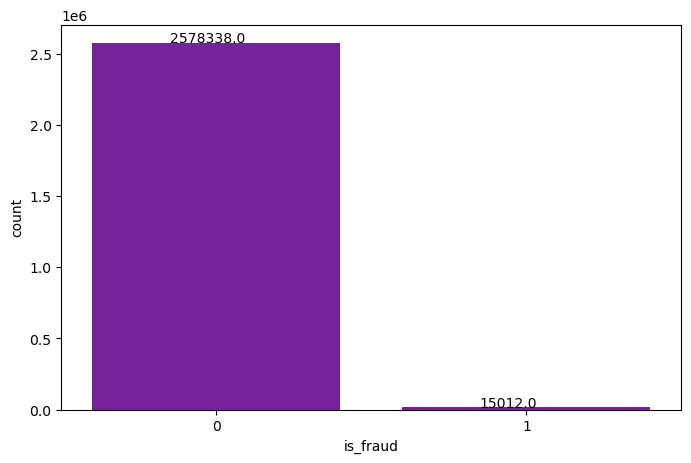

In [181]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x="is_fraud", data=total,color=randomcolor())
for p in ax.patches:
     ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()


only around 10,000 entries represent fraud transactions out of nearly 1.8 million entries, hence we are looking at an imbalanced dataset.

creating age variable from transaction dates and DOB.

In [182]:
total["age"] = total["trans_date"]-total["dob"]
total["age"]=total["age"].astype('timedelta64[Y]')
total["age"].head()

0    30.0
1    40.0
2    56.0
3    51.0
4    32.0
Name: age, dtype: float64

In [183]:
total.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2593350 entries, 0 to 1296674
Data columns (total 16 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   category               object        
 2   amt                    float64       
 3   gender                 object        
 4   city                   object        
 5   state                  object        
 6   lat                    float64       
 7   long                   float64       
 8   city_pop               int64         
 9   job                    object        
 10  dob                    datetime64[ns]
 11  merch_lat              float64       
 12  merch_long             float64       
 13  is_fraud               int64         
 14  trans_date             datetime64[ns]
 15  age                    float64       
dtypes: datetime64[ns](3), float64(6), int64(2), object(5)
memory usage: 368.6+ MB


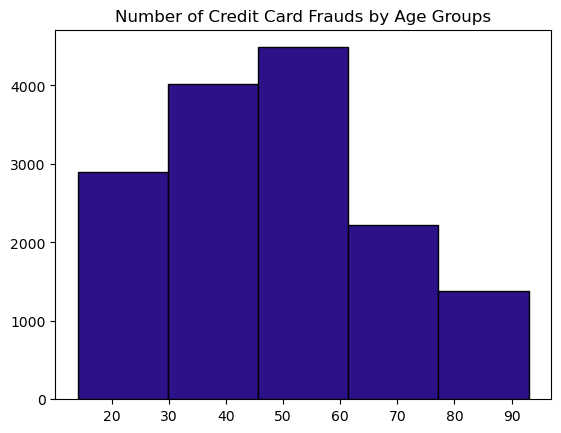

In [184]:
fraud=total[total["is_fraud"]==1]
fig, ax = plt.subplots()
ax.hist(fraud.age, edgecolor = "black", bins = 5, color=randomcolor())
plt.title("Number of Credit Card Frauds by Age Groups")
plt.show()


creating transacation month and transaction year columns

In [185]:
total['trans_month'] = pd.DatetimeIndex(total['trans_date']).month
total['trans_year'] = pd.DatetimeIndex(total['trans_date']).year

In [186]:
total['Month_name'] = total['trans_month'].apply(lambda x: calendar.month_abbr[x])

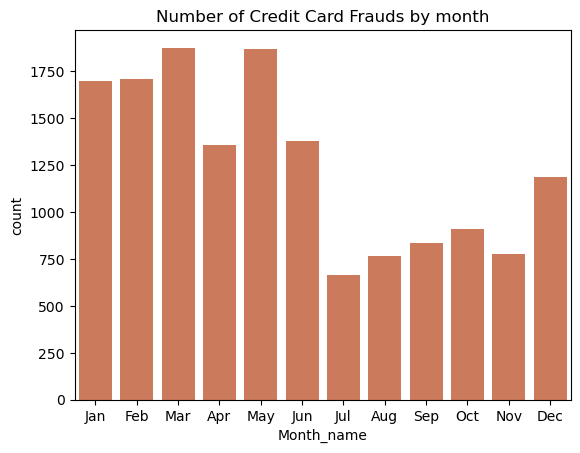

In [187]:
sns.countplot(x=total[total["is_fraud"]==1]["Month_name"],color=randomcolor())
plt.title("Number of Credit Card Frauds by month")
plt.show()
del total['Month_name']

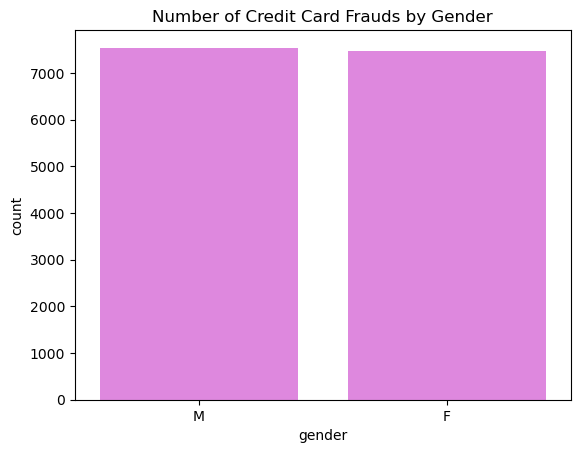

In [188]:
sns.countplot(x=total[total["is_fraud"]==1]["gender"],color=randomcolor())
plt.title("Number of Credit Card Frauds by Gender")
plt.show()

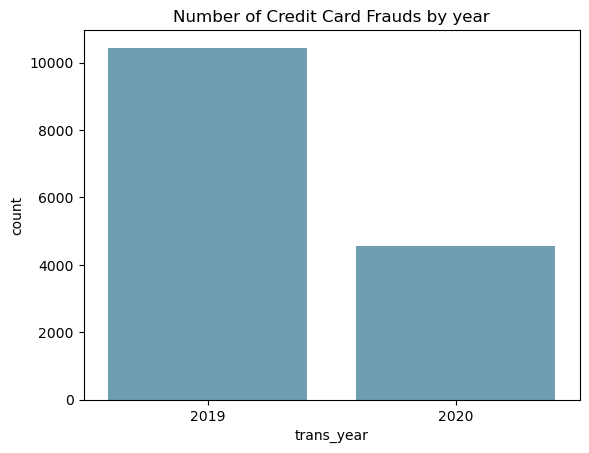

In [189]:
sns.countplot(x=total[total["is_fraud"]==1]["trans_year"],color=randomcolor())
plt.title("Number of Credit Card Frauds by year")
plt.show()

In [190]:
# Finding distance from customer location to merchant location in degrees latitude and degrees longitude
total['latitudinal_distance'] = abs(round(total['merch_lat']-total['lat'],3))
total['longitudinal_distance'] = abs(round(total['merch_long']-total['long'],3))

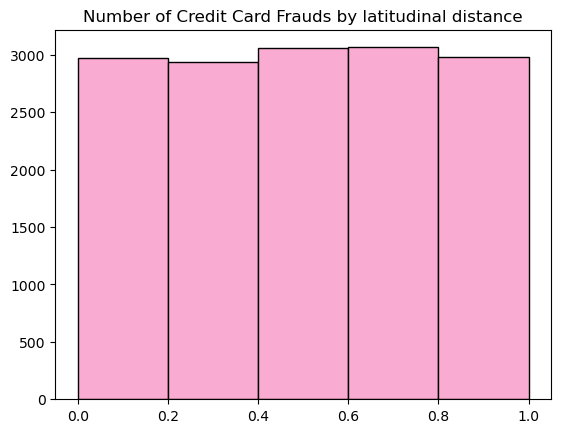

In [191]:
fraud = total[total["is_fraud"]==1]
fig, ax = plt.subplots()
ax.hist(fraud.latitudinal_distance, edgecolor = "black", bins = 5, color=randomcolor())
plt.title("Number of Credit Card Frauds by latitudinal distance")
plt.show()

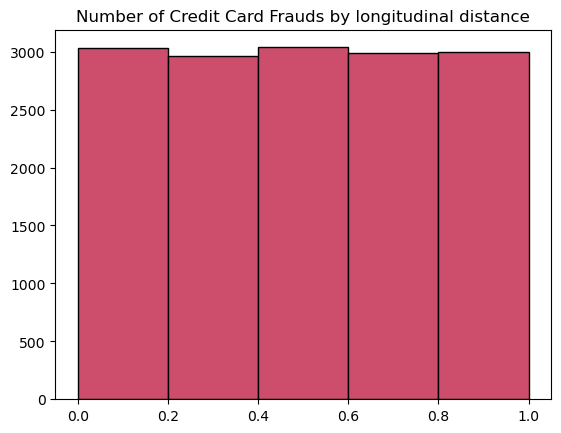

In [192]:
fig, ax = plt.subplots()
ax.hist(fraud.longitudinal_distance, edgecolor = "black", bins = 5, color=randomcolor())
plt.title("Number of Credit Card Frauds by longitudinal distance")
plt.show()

In [193]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2593350 entries, 0 to 1296674
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   category               object        
 2   amt                    float64       
 3   gender                 object        
 4   city                   object        
 5   state                  object        
 6   lat                    float64       
 7   long                   float64       
 8   city_pop               int64         
 9   job                    object        
 10  dob                    datetime64[ns]
 11  merch_lat              float64       
 12  merch_long             float64       
 13  is_fraud               int64         
 14  trans_date             datetime64[ns]
 15  age                    float64       
 16  trans_month            int64         
 17  trans_year             int64         
 18  latitudinal_distance  

Changing gender values to binary values

In [194]:
total.gender.value_counts()

F    1419726
M    1173624
Name: gender, dtype: int64

In [195]:
total.gender=total.gender.apply(lambda x: 1 if x=="M" else 0)
total.gender.value_counts()

0    1419726
1    1173624
Name: gender, dtype: int64

Dropping final set of variables not useful for model building

In [196]:
drop_cols = ['trans_date_trans_time','city','lat','long','job','dob','merch_lat','merch_long','trans_date','state']
total=total.drop(drop_cols,axis=1)
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2593350 entries, 0 to 1296674
Data columns (total 10 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   category               object 
 1   amt                    float64
 2   gender                 int64  
 3   city_pop               int64  
 4   is_fraud               int64  
 5   age                    float64
 6   trans_month            int64  
 7   trans_year             int64  
 8   latitudinal_distance   float64
 9   longitudinal_distance  float64
dtypes: float64(4), int64(5), object(1)
memory usage: 249.9+ MB


In [197]:
total = pd.get_dummies(total,columns=['category'],drop_first=True)
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2593350 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   amt                      float64
 1   gender                   int64  
 2   city_pop                 int64  
 3   is_fraud                 int64  
 4   age                      float64
 5   trans_month              int64  
 6   trans_year               int64  
 7   latitudinal_distance     float64
 8   longitudinal_distance    float64
 9   category_food_dining     uint8  
 10  category_gas_transport   uint8  
 11  category_grocery_net     uint8  
 12  category_grocery_pos     uint8  
 13  category_health_fitness  uint8  
 14  category_home            uint8  
 15  category_kids_pets       uint8  
 16  category_misc_net        uint8  
 17  category_misc_pos        uint8  
 18  category_personal_care   uint8  
 19  category_shopping_net    uint8  
 20  category_shopping_pos    uint8  
 21  category

In [198]:
total.head()

,amt,gender,city_pop,is_fraud,age,trans_month,trans_year,latitudinal_distance,longitudinal_distance,category_food_dining,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,4.97,0,3495,0,30.0,1,2019,0.068,0.870,0,...,0,0,0,0,1,0,0,0,0,0
1,107.23,0,149,0,40.0,1,2019,0.271,0.024,0,...,1,0,0,0,0,0,0,0,0,0
2,220.11,1,4154,0,56.0,1,2019,0.970,0.108,0,...,0,0,0,0,0,0,0,0,0,0
3,45.00,1,1939,0,51.0,1,2019,0.804,0.447,0,...,0,0,0,0,0,0,0,0,0,0
4,41.96,1,99,0,32.0,1,2019,0.254,0.830,0,...,0,0,0,0,0,1,0,0,0,0


# Model Building


In [199]:
# Creating two different dataframe of majority and minority class 
df_majority = total[(total['is_fraud']==0)] 
df_minority = total[(total['is_fraud']==1)] 

df_majority.shape,df_minority.shape

((2578338, 22), (15012, 22))

In [200]:
# Upsampling minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 1842743, # to match majority class
                                 random_state=42)  # reproducible results
df_minority_upsampled.shape

(1842743, 22)

In [201]:
# Combining majority class with upsampled minority class
total_upsampled = pd.concat([df_minority_upsampled, df_majority])
total_upsampled.shape

(4421081, 22)

In [202]:
x_cols = list(total_upsampled.columns)
x_cols.remove('is_fraud')
x_cols

['amt',
 'gender',
 'city_pop',
 'age',
 'trans_month',
 'trans_year',
 'latitudinal_distance',
 'longitudinal_distance',
 'category_food_dining',
 'category_gas_transport',
 'category_grocery_net',
 'category_grocery_pos',
 'category_health_fitness',
 'category_home',
 'category_kids_pets',
 'category_misc_net',
 'category_misc_pos',
 'category_personal_care',
 'category_shopping_net',
 'category_shopping_pos',
 'category_travel']

In [203]:
X = total_upsampled[x_cols]
Y = total_upsampled['is_fraud']
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4421081 entries, 1261427 to 1296674
Data columns (total 21 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   amt                      float64
 1   gender                   int64  
 2   city_pop                 int64  
 3   age                      float64
 4   trans_month              int64  
 5   trans_year               int64  
 6   latitudinal_distance     float64
 7   longitudinal_distance    float64
 8   category_food_dining     uint8  
 9   category_gas_transport   uint8  
 10  category_grocery_net     uint8  
 11  category_grocery_pos     uint8  
 12  category_health_fitness  uint8  
 13  category_home            uint8  
 14  category_kids_pets       uint8  
 15  category_misc_net        uint8  
 16  category_misc_pos        uint8  
 17  category_personal_care   uint8  
 18  category_shopping_net    uint8  
 19  category_shopping_pos    uint8  
 20  category_travel          uint8  
dtypes:

In [204]:
X_train, X_test, Y_train, Y_test = train_test_split(
X, Y, test_size=0.3, random_state=42)

Scaling the X-Variable

In [56]:
sc= StandardScaler()
X_train_std= sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

Feature Importances

In [57]:
logit_model= LogisticRegression(solver='liblinear')
logit_model.fit(X_train_std, Y_train)

LogisticRegression(solver='liblinear')

In [58]:
feature= pd.DataFrame()
feature['column']= X_train.columns
feature['importance']= logit_model.coef_[0]
feature.sort_values('importance', ascending=False, inplace=True)
feature

,column,importance
0,amt,3.697634
9,category_gas_transport,0.754719
11,category_grocery_pos,0.646083
17,category_personal_care,0.425213
14,category_kids_pets,0.417534
16,category_misc_pos,0.388319
10,category_grocery_net,0.353859
20,category_travel,0.316323
12,category_health_fitness,0.289566
8,category_food_dining,0.279700


## Logistic Regression


In [59]:
Logit1=LogisticRegression(solver='liblinear')

Logit1.fit(X_train_std,Y_train)

print("Score of the model with X-train and Y-train is : ", str(round(Logit1.score(X_train,Y_train)*100,2)),"%")
print("Score of the model with X-test and Y-test is : ", str(round(Logit1.score(X_test,Y_test)*100,2)),"%")

Y_pred=Logit1.predict(X_test_std)

print( " Mean absolute error is ",( mean_absolute_error(Y_test,Y_pred)))
print(" Mean squared  error is " , mean_squared_error(Y_test,Y_pred))
print(" Median absolute error is " ,median_absolute_error(Y_test,Y_pred)) 
print("Accuracy is " , round(accuracy_score(Y_test,Y_pred)*100,2),"%")
print("F1 score: ", round(f1_score(Y_test, Y_pred, average='weighted')*100,2),"%")

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Score of the model with X-train and Y-train is :  53.74 %


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Score of the model with X-test and Y-test is :  53.77 %
 Mean absolute error is  0.1334145100182836
 Mean squared  error is  0.1334145100182836
 Median absolute error is  0.0
Accuracy is  86.66 %
F1 score:  86.37 %


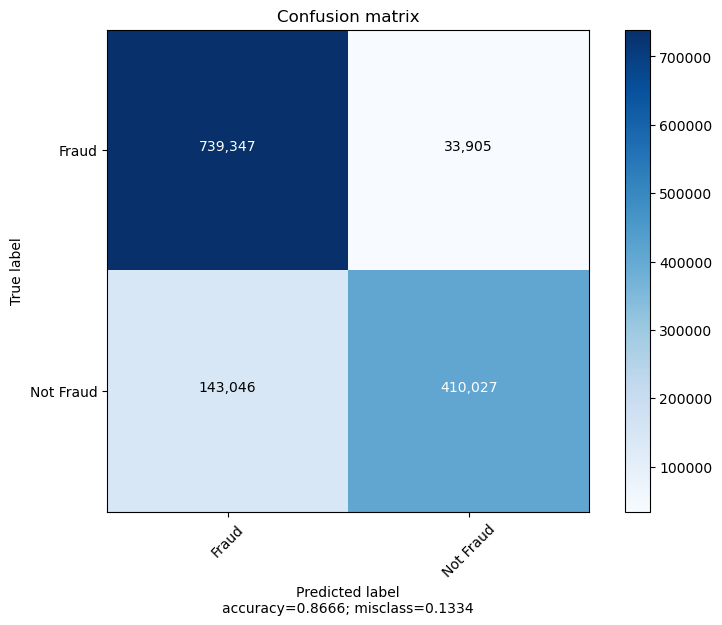

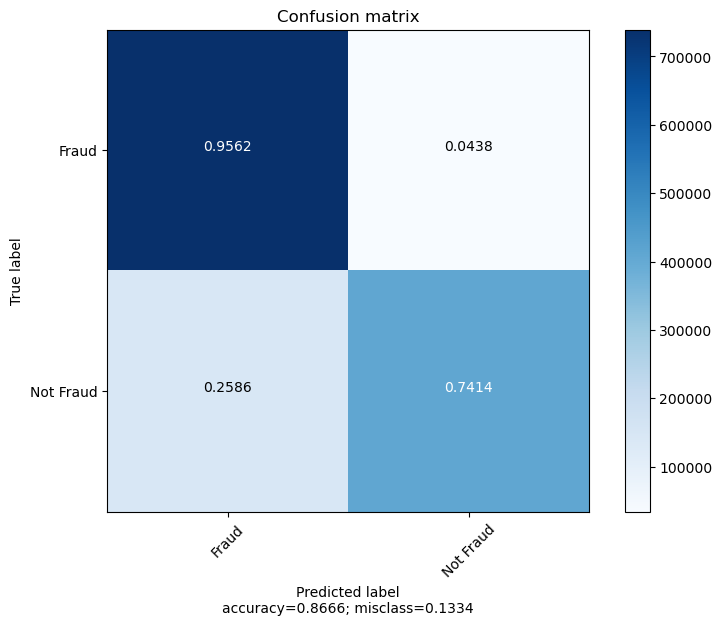

In [82]:

plot_confusion_matrix(confusion_matrix(Y_test,Y_pred),["Fraud","Not Fraud"],normalize=False)
plot_confusion_matrix(confusion_matrix(Y_test,Y_pred),["Fraud","Not Fraud"],normalize=True)

Fine Tuning

In [60]:
X_train_new=X_train[[x for x in feature[feature["importance"]>0].column]]
X_test_new=X_test[[x for x in feature[feature["importance"]>0].column]]

In [73]:
X_train_sm = sm.add_constant(X_train_new)
logm = sm.GLM(Y_train, X_train_sm, family = sm.families.Binomial())
res = logm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               is_fraud   No. Observations:              3094756
Model:                            GLM   Df Residuals:                  3094741
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1218e+06
Date:                Thu, 13 Apr 2023   Deviance:                   2.2436e+06
Time:                        16:57:11   Pearson chi2:                 1.33e+18
No. Iterations:                     8   Pseudo R-squ. (CS):             0.4693
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -4.4149      0.010   -448.089      0.000      -4.434      -4.396
amt                         0.0097   1.45e-05    665.866      0.000       0.010       0.010
category_gas_transport      3.2728      0.009    372.940      0.000       3.256       3.290
category_grocery_pos        2.5858      0.007    364.259      0.000       2.572       2.600
category_personal_care      2.5852      0.010    261.934      0.000       2.566       2.605
category_kids_pets          2.3981      0.010    250.277      0.000       2.379       2.417
category_misc_pos           2.4717      0.010    237.317      0.000       2.451       2.492
category_grocery_net        2.8273      0.011    255.838      0.000       2.806       2.849
category_travel             2.7122      0.013    214.942      0.000       2.687       2.737
category_health_fitness     2.0731      0.011    194.262      0.000       2.052       2.094
category_food_dining        1.9951      0.010    194.619      0.000       1.975       2.015
category_home               1.5365      0.009    162.322      0.000       1.518       1.555
age                         0.0030   9.41e-05     31.373      0.000       0.003       0.003
latitudinal_distance        0.0252      0.006      4.330      0.000       0.014       0.037
city_pop                 2.855e-08   5.47e-09      5.216      0.000    1.78e-08    3.93e-08
===========================================================================================
"""

In [74]:
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values, i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
11,age,4.52
12,latitudinal_distance,3.26
0,amt,1.93
2,category_grocery_pos,1.39
1,category_gas_transport,1.34
4,category_kids_pets,1.21
10,category_home,1.20
3,category_personal_care,1.18
8,category_health_fitness,1.15
9,category_food_dining,1.15


In [75]:
# Since all the columns have VIF<5, we'll continue with all columns
#x_train_vif_adj = X_train_new[[x for x in list(vif[vif['VIF']<=5]['Features'])]]
x_train_vif_adj = X_train_new
#x_test_vif_adj = X_test_new[[x for x in list(vif[vif['VIF']<=5]['Features'])]]
x_test_vif_adj = X_test_new 

In [76]:
# Scaling the new test and train sets
sc= StandardScaler()
X_train_vif_adj_std=sc.fit_transform(x_train_vif_adj)
X_test_vif_adj_std = sc.fit_transform(x_test_vif_adj)

Training a new Logistic Regression Model to reflect the changes:-

In [83]:
Logit2=LogisticRegression(solver='liblinear')

Logit2.fit(X_train_vif_adj_std,Y_train)

print("Score of the model with X-train and Y-train is : ", str(round(Logit2.score(X_train_vif_adj_std,Y_train)*100,2)),"%")
print("Score of the model with X-test and Y-test is : ", str(round(Logit2.score(X_test_vif_adj_std,Y_test)*100,2)),"%")

Y_pred=Logit2.predict(X_test_vif_adj_std)

print( " Mean absolute error is ",( mean_absolute_error(Y_test,Y_pred)))
print(" Mean squared  error is " , mean_squared_error(Y_test,Y_pred))
print(" Median absolute error is " ,median_absolute_error(Y_test,Y_pred)) 
print("Accuracy is " , round(accuracy_score(Y_test,Y_pred)*100,2),"%")
print("F1 score: ", round(f1_score(Y_test, Y_pred, average='weighted')*100,2),"%")

Score of the model with X-train and Y-train is :  86.51 %
Score of the model with X-test and Y-test is :  86.59 %
 Mean absolute error is  0.13408101332629635
 Mean squared  error is  0.13408101332629635
 Median absolute error is  0.0
Accuracy is  86.59 %
F1 score:  86.27 %


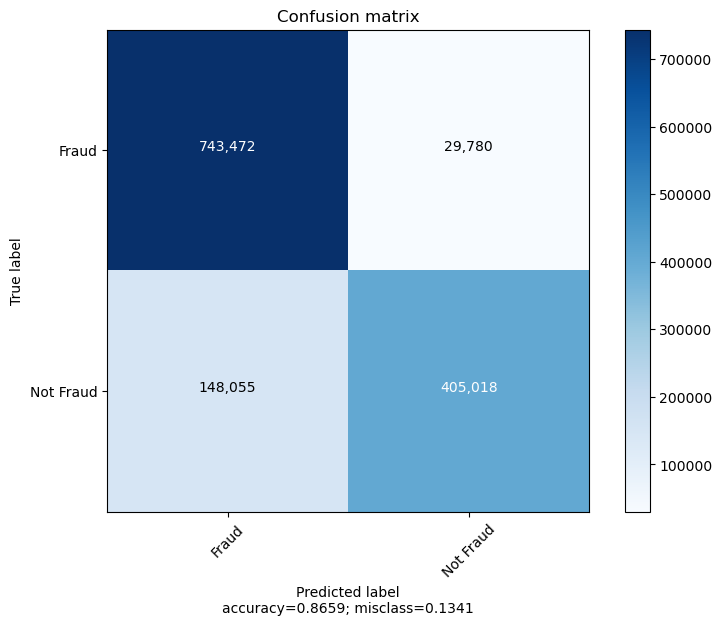

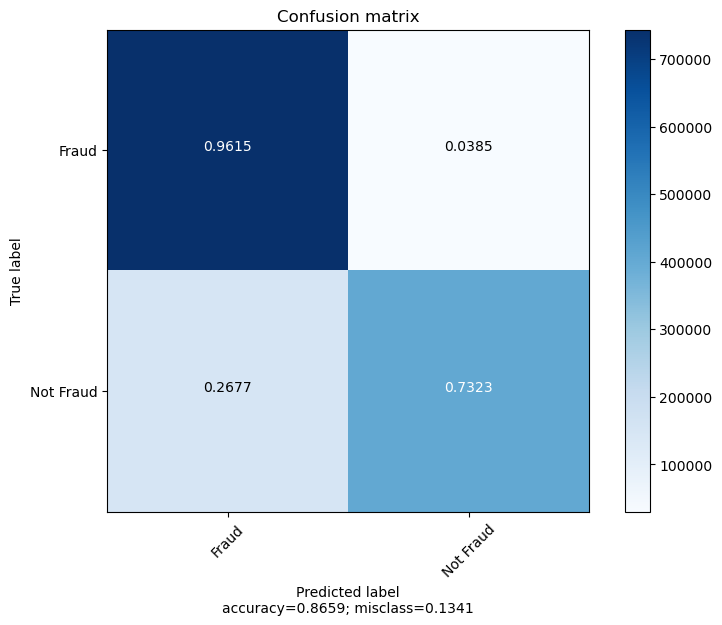

In [84]:
plot_confusion_matrix(confusion_matrix(Y_test,Y_pred),["Fraud","Not Fraud"],normalize=False)
plot_confusion_matrix(confusion_matrix(Y_test,Y_pred),["Fraud","Not Fraud"],normalize=True)

In [85]:
matrix = classification_report(Y_test,Y_pred,labels=[1,0])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           1       0.93      0.73      0.82    553073
           0       0.83      0.96      0.89    773252

    accuracy                           0.87   1326325
   macro avg       0.88      0.85      0.86   1326325
weighted avg       0.87      0.87      0.86   1326325



In [86]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


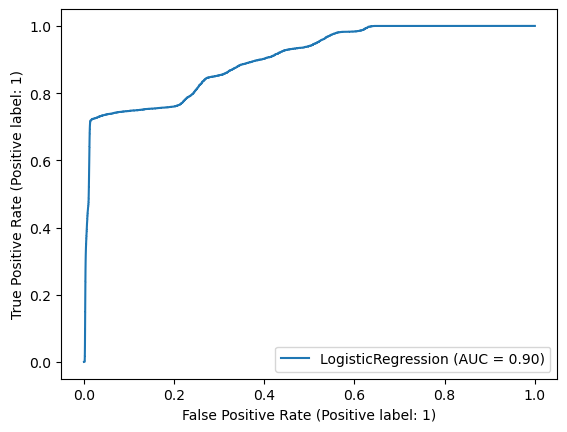

In [87]:
RocCurveDisplay.from_estimator(Logit2, X_test_vif_adj_std, Y_test)
plt.show()

## Decision Tree


In [88]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train,Y_train)

DecisionTreeClassifier()

Feature Importances using Decision Tree

amt -  0.7279306204232896
gender -  0.003817825948494533
city_pop -  0.02189130906043214
age -  0.027998244012661818
trans_month -  0.007355786357042045
trans_year -  0.0008321574336655578
latitudinal_distance -  0.013418098048098936
longitudinal_distance -  0.014773899320968401
category_food_dining -  0.010350533522218233
category_gas_transport -  0.07990179391047283
category_grocery_net -  0.023115972462103736
category_grocery_pos -  0.0015382097394266365
category_health_fitness -  0.002127148282329805
category_home -  0.014797218794169412
category_kids_pets -  0.0035387817039677135
category_misc_net -  0.0026903578848448554
category_misc_pos -  0.011777807922889467
category_personal_care -  0.0029797513032420657
category_shopping_net -  0.009088807700201585
category_shopping_pos -  0.005370547907652774
category_travel -  0.014705128261827715


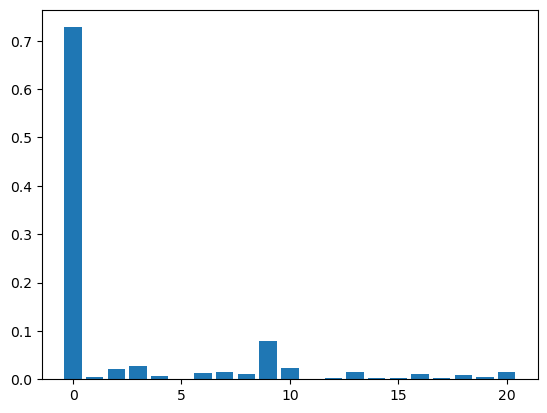

In [89]:
importance = dtc.feature_importances_
for i,v in enumerate(importance):
    print(X_train.columns[int(i)],"- ",v)
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [90]:
print("Score the X-train with Y-train is : ", dtc.score(X_train,Y_train))
print("Score the X-test  with Y-test  is : ", dtc.score(X_test,Y_test))

Y_pred=dtc.predict(X_test)

print( " Mean absolute error is ", mean_absolute_error(Y_test,Y_pred))
print(" Mean squared  error is " , mean_squared_error(Y_test,Y_pred))
print(" Median absolute error is " ,median_absolute_error(Y_test,Y_pred)) 
print("Accuracy score " , accuracy_score(Y_test,Y_pred))
print("F1 score: ", round(f1_score(Y_test, Y_pred, average='weighted')*100,2),"%")

Score the X-train with Y-train is :  1.0
Score the X-test  with Y-test  is :  0.9997134940531167
 Mean absolute error is  0.0002865059468833054
 Mean squared  error is  0.0002865059468833054
 Median absolute error is  0.0
Accuracy score  0.9997134940531167
F1 score:  99.97 %


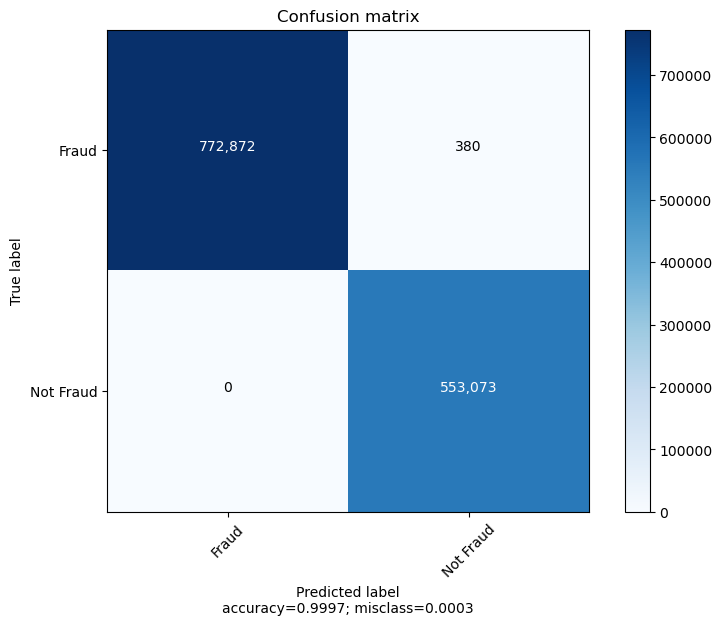

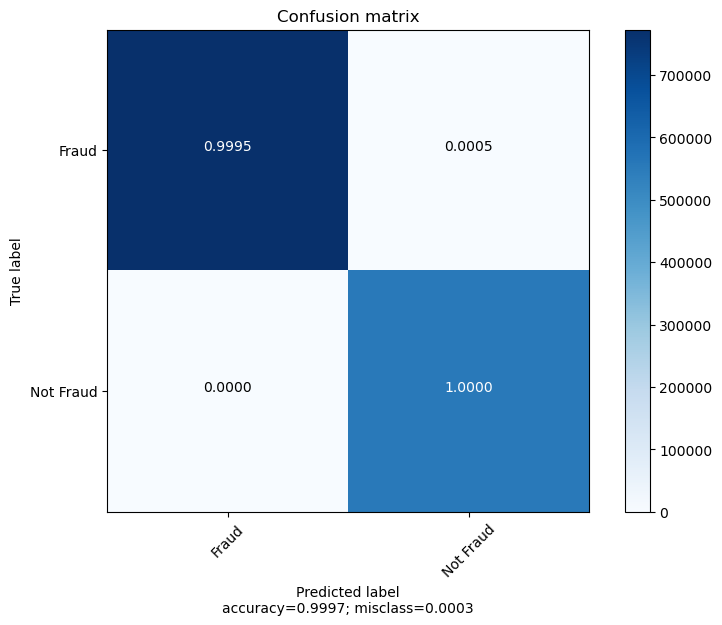

In [91]:
plot_confusion_matrix(confusion_matrix(Y_test,Y_pred),["Fraud","Not Fraud"],normalize=False)
plot_confusion_matrix(confusion_matrix(Y_test,Y_pred),["Fraud","Not Fraud"],normalize=True)

Perfect score on training set indicates overfitting. Using hyperparameter tuning.

### Hyperparameter Tuning

In [92]:
#Normal Randomised Search takes too much time to execute on a dataset this large.
"""dtc1 = DecisionTreeClassifier()


params_dtc = {  
    "splitter":["best"],
    'max_depth': [10, 20, 50, 100, 200],
    'min_samples_leaf': [10, 20, 50, 100, 200],
    'min_samples_split' : [10, 20, 50, 100, 200],
    'criterion': ["gini", "entropy"]
}
random_search=RandomizedSearchCV(estimator=dtc1,param_distributions = params_dtc, scoring = 'f1',cv=5,n_iter=100)
random_search.fit(X_train,Y_train)"""

'dtc1 = DecisionTreeClassifier()\n\n\nparams_dtc = {  \n    "splitter":["best"],\n    \'max_depth\': [10, 20, 50, 100, 200],\n    \'min_samples_leaf\': [10, 20, 50, 100, 200],\n    \'min_samples_split\' : [10, 20, 50, 100, 200],\n    \'criterion\': ["gini", "entropy"]\n}\nrandom_search=RandomizedSearchCV(estimator=dtc1,param_distributions = params_dtc, scoring = \'f1\',cv=5,n_iter=100)\nrandom_search.fit(X_train,Y_train)'

Since dataset is very large(close to 1.8 million rows originally and even more after treating for unbalanced condition), we will use halving randomized search cross validation which is an experimental variant of the randomised search, much faster compared to either randomised search or grid search cross validation.

In [93]:
dtc1 = DecisionTreeClassifier()

params_dtc = {
    'max_depth': [10, 20, 50, 100, 200],
    'min_samples_leaf': [10, 20, 50, 100, 200],
    'min_samples_split' : [10, 20, 50, 100, 200],
    'criterion': ["gini", "entropy"]
} 

halving_random_search=HalvingRandomSearchCV(estimator=dtc1,param_distributions = params_dtc,cv=5)
halving_random_search.fit(X_train,Y_train)
print(halving_random_search.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 250 is smaller than n_iter=154737. Running 250 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


{'min_samples_split': 100, 'min_samples_leaf': 10, 'max_depth': 20, 'criterion': 'gini'}


In [94]:
print(halving_random_search.best_params_)

{'min_samples_split': 100, 'min_samples_leaf': 10, 'max_depth': 20, 'criterion': 'gini'}


In [95]:
dtc2 = DecisionTreeClassifier(min_samples_split= 100, min_samples_leaf= 20, max_depth= 200, criterion= 'gini')
dtc2.fit(X_train,Y_train)

DecisionTreeClassifier(max_depth=200, min_samples_leaf=20,
                       min_samples_split=100)

In [96]:
print("Score the X-train with Y-train is : ", dtc2.score(X_train,Y_train))
print("Score the X-test  with Y-test  is : ", dtc2.score(X_test,Y_test))

Y_pred=dtc2.predict(X_test)

print( " Mean absolute error is ", mean_absolute_error(Y_test,Y_pred))
print(" Mean squared  error is " , mean_squared_error(Y_test,Y_pred))
print(" Median absolute error is " ,median_absolute_error(Y_test,Y_pred)) 
print("Accuracy score " , accuracy_score(Y_test,Y_pred))
print("F1 score: ", round(f1_score(Y_test, Y_pred, average='weighted')*100,2),"%")

Score the X-train with Y-train is :  0.997758789384365
Score the X-test  with Y-test  is :  0.9974093830697605
 Mean absolute error is  0.0025906169302395716
 Mean squared  error is  0.0025906169302395716
 Median absolute error is  0.0
Accuracy score  0.9974093830697605
F1 score:  99.74 %


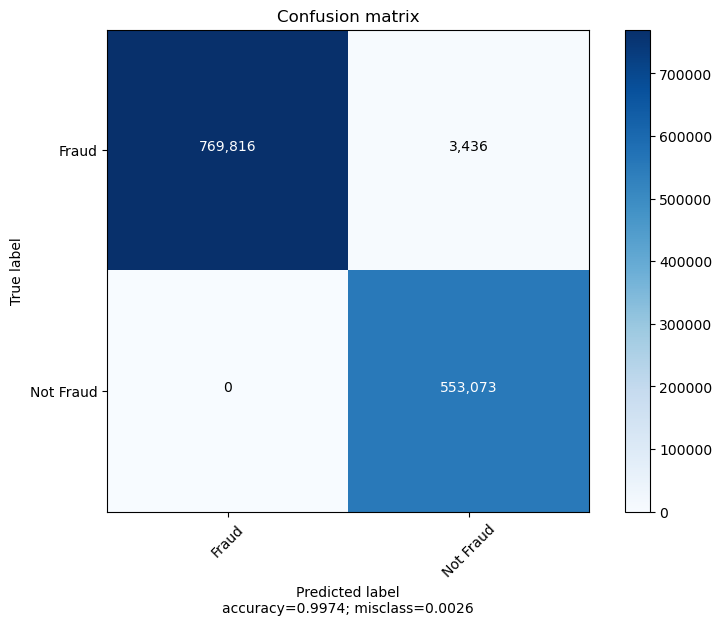

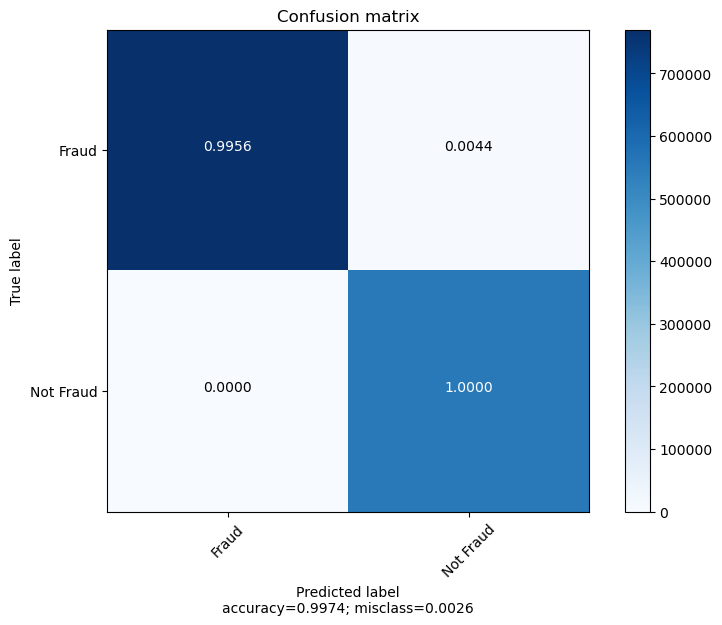

In [97]:
plot_confusion_matrix(confusion_matrix(Y_test,Y_pred),["Fraud","Not Fraud"],normalize=False)
plot_confusion_matrix(confusion_matrix(Y_test,Y_pred),["Fraud","Not Fraud"],normalize=True)

In [99]:
matrix = classification_report(Y_test,Y_pred,labels=[1,0])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           1       0.99      1.00      1.00    553073
           0       1.00      1.00      1.00    773252

    accuracy                           1.00   1326325
   macro avg       1.00      1.00      1.00   1326325
weighted avg       1.00      1.00      1.00   1326325



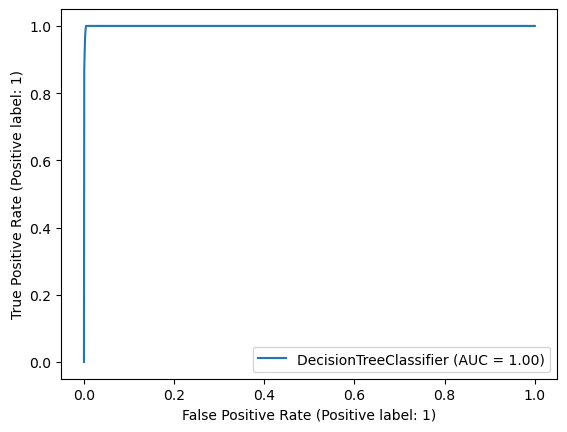

In [100]:
RocCurveDisplay.from_estimator(dtc2, X_test, Y_test)
plt.show()

In accordance with the confusion matrix, the roc curve is almost perfect.

# ADA Boost

In [54]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier

In [58]:
# Create adaboost classifer object
dtc = DecisionTreeClassifier()
abc = AdaBoostClassifier(n_estimators=100, base_estimator=dtc,learning_rate=1.0, random_state=0)

# Train Adaboost Classifer
abc.fit(X_train, Y_train)

#Predict the response for test dataset
y_pred_lg = abc.predict(X_test)

In [59]:
precision_score_ab =  precision_score(Y_test, y_pred_lg)
accuracy_score_ab = accuracy_score(Y_test, y_pred_lg)
print('The precision score is : ',round(precision_score_ab * 100,2), '%')
print('The accuracy score is : ',round(accuracy_score_ab * 100,2), '%')
print ('\nClassification Report TEST:\n', classification_report(Y_test,y_pred_lg))

The precision score is :  99.93 %
The accuracy score is :  99.97 %

Classification Report TEST:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    773252
           1       1.00      1.00      1.00    553073

    accuracy                           1.00   1326325
   macro avg       1.00      1.00      1.00   1326325
weighted avg       1.00      1.00      1.00   1326325



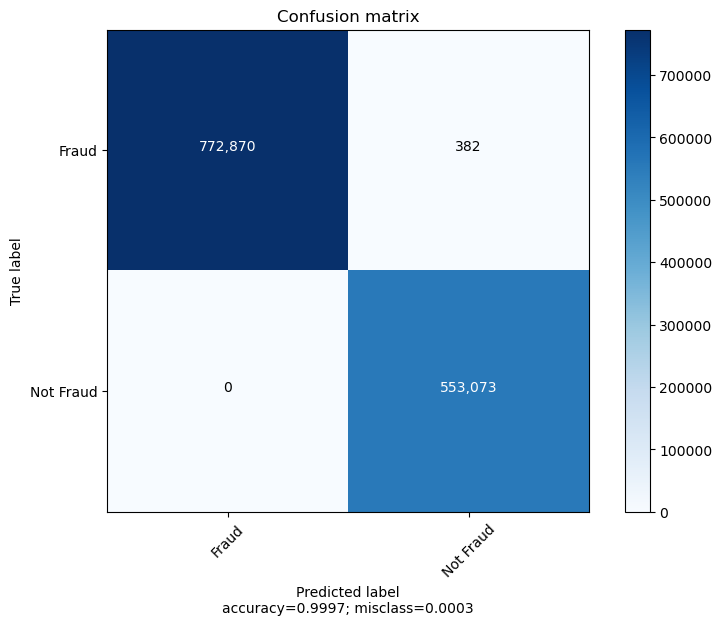

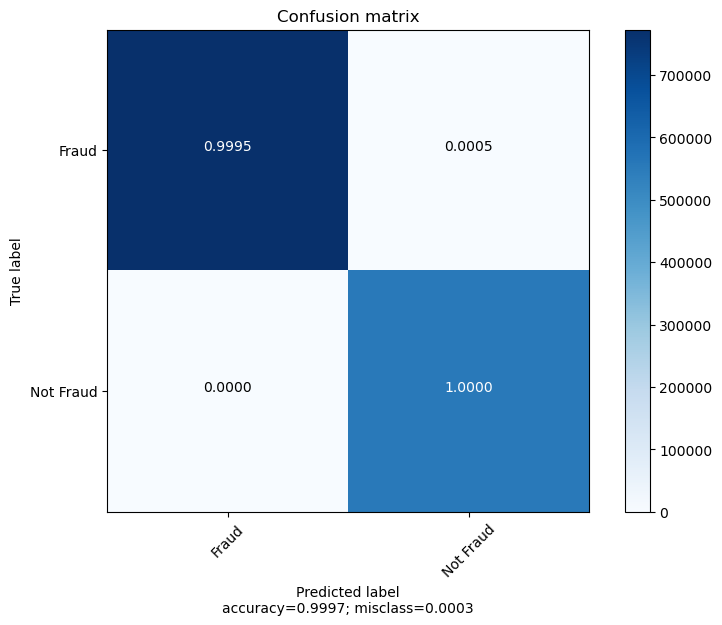

In [61]:
plot_confusion_matrix(confusion_matrix(Y_test,y_pred_lg),["Fraud","Not Fraud"],normalize=False)
plot_confusion_matrix(confusion_matrix(Y_test,y_pred_lg),["Fraud","Not Fraud"],normalize=True)

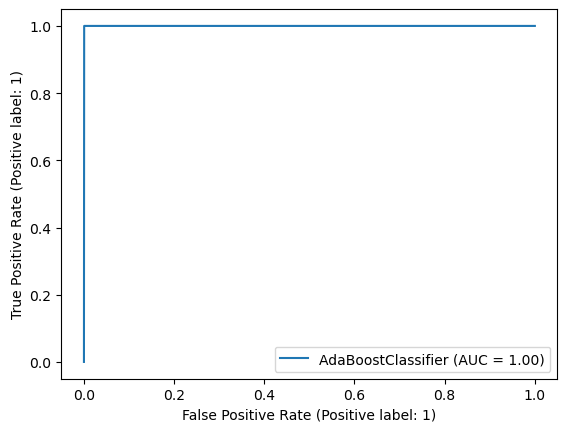

In [62]:
RocCurveDisplay.from_estimator(abc, X_test, Y_test)
plt.show()

In [63]:
matrix = classification_report(Y_test,y_pred_lg,labels=[1,0])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00    553073
           0       1.00      1.00      1.00    773252

    accuracy                           1.00   1326325
   macro avg       1.00      1.00      1.00   1326325
weighted avg       1.00      1.00      1.00   1326325



# Auto-Sklearn

In [205]:
!pip install auto-sklearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 41.6 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 68.6 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 66.6 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 50.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.9 MB/s eta 0:00:00
  Created wheel for auto-sklearn: filename=auto_sklearn-0.15.0-py3-none-any.whl size=6641946 sha256=774379df19e12d05986ed7f074bc98a5db635ead856b4a62bf5d19b220c71f7b
  Stored in directory: /root/.cache/pip/wheels/2b/0b/d7/8f19de

In [207]:
import autosklearn.classification

In [209]:
%%time
automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=9000 ,memory_limit = 15400,)
automl.fit(X_train, Y_train)

[WARNING] [2023-04-13 21:28:53,413:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-04-13 21:43:55,869:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-04-13 21:45:05,078:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-04-13 22:00:07,114:Client-EnsembleBuilder] No runs were available to build an ensemble from
CPU times: user 5.99 s, sys: 10.9 s, total: 16.9 s
Wall time: 2h 29min 49s


AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      memory_limit=15400, per_run_time_limit=900,
                      time_left_for_this_task=9000)

In [210]:
y_hat = automl.predict(X_test)


In [211]:
print("Accuracy score", accuracy_score(Y_test, y_hat))

Accuracy score 0.973132527849509


In [212]:
matrix = confusion_matrix(Y_test,y_hat, labels=[1,0])
print('Confusion matrix : \n',matrix)


tp, fn, fp, tn = confusion_matrix(Y_test,y_hat,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)


matrix = classification_report(Y_test,y_hat,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[533013  20060]
 [ 15575 757677]]
Outcome values : 
 533013 20060 15575 757677
Classification report : 
               precision    recall  f1-score   support

           1       0.97      0.96      0.97    553073
           0       0.97      0.98      0.98    773252

    accuracy                           0.97   1326325
   macro avg       0.97      0.97      0.97   1326325
weighted avg       0.97      0.97      0.97   1326325



In [213]:
a_sklrn_df = pd.DataFrame.from_dict(automl.cv_results_)

In [214]:
a_sklrn_df = a_sklrn_df.sort_values(by=["mean_test_score"],ascending = False)

In [215]:
a_sklrn_df.to_csv('autosklearn.csv', index=True)

In [216]:
a_sklrn_df

,mean_test_score,rank_test_scores,mean_fit_time,params,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessor:__choice__,param_feature_preprocessor:__choice__,...,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_max,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_min,param_feature_preprocessor:fast_ica:n_components,param_feature_preprocessor:kernel_pca:coef0,param_feature_preprocessor:kernel_pca:degree,param_feature_preprocessor:kernel_pca:gamma,param_feature_preprocessor:nystroem_sampler:coef0,param_feature_preprocessor:nystroem_sampler:degree,param_feature_preprocessor:nystroem_sampler:gamma,param_feature_preprocessor:select_rates_classification:mode
7,0.962022,1,877.395757,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,mlp,feature_type,feature_agglomeration,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0.927931,2,88.977347,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,k_nearest_neighbors,feature_type,liblinear_svc_preprocessor,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.873522,3,161.219355,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,sgd,feature_type,select_percentile_classification,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.000000,4,900.157076,"{'balancing:strategy': 'none', 'classifier:__c...",Timeout,0.0,none,random_forest,feature_type,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,4,900.109784,"{'balancing:strategy': 'weighting', 'classifie...",Timeout,0.0,weighting,random_forest,feature_type,feature_agglomeration,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000,4,67.177574,"{'balancing:strategy': 'none', 'classifier:__c...",Crash,0.0,none,libsvm_svc,feature_type,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000000,4,900.156446,"{'balancing:strategy': 'weighting', 'classifie...",Timeout,0.0,weighting,gradient_boosting,feature_type,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.000000,4,900.115964,"{'balancing:strategy': 'weighting', 'classifie...",Timeout,0.0,weighting,extra_trees,feature_type,feature_agglomeration,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.000000,4,900.075421,"{'balancing:strategy': 'none', 'classifier:__c...",Timeout,0.0,none,mlp,feature_type,feature_agglomeration,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.000000,4,7.576273,"{'balancing:strategy': 'none', 'classifier:__c...",Memout,0.0,none,gradient_boosting,feature_type,polynomial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [217]:
precision_score_ab =  precision_score(Y_test, y_hat)
accuracy_score_ab = accuracy_score(Y_test, y_hat)
print('The precision score is : ',round(precision_score_ab * 100,2), '%')
print('The accuracy score is : ',round(accuracy_score_ab * 100,2), '%')
print ('\nClassification Report TEST:\n', classification_report(Y_test,y_hat))

The precision score is :  97.16 %
The accuracy score is :  97.31 %

Classification Report TEST:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98    773252
           1       0.97      0.96      0.97    553073

    accuracy                           0.97   1326325
   macro avg       0.97      0.97      0.97   1326325
weighted avg       0.97      0.97      0.97   1326325



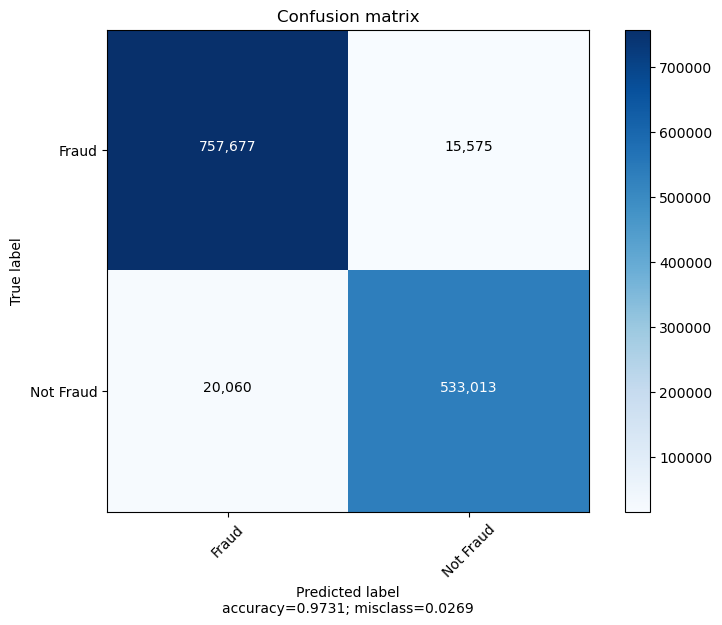

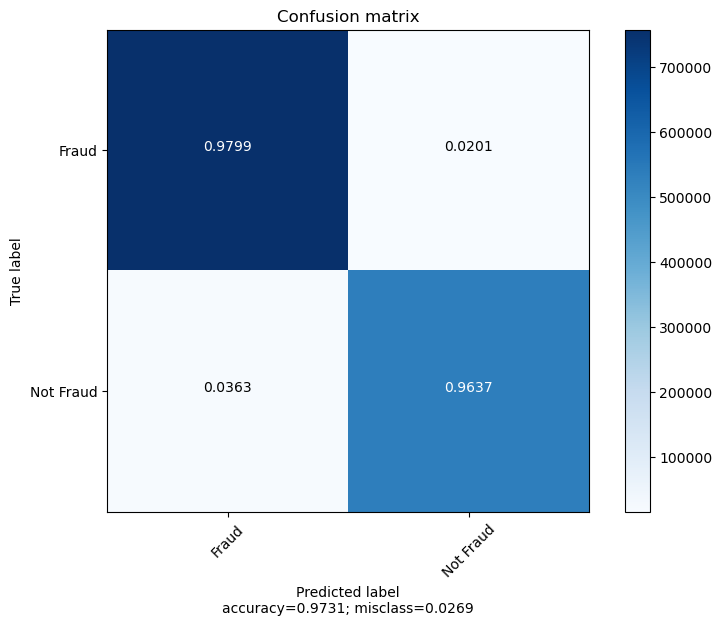

In [219]:
plot_confusion_matrix(confusion_matrix(Y_test,y_hat),["Fraud","Not Fraud"],normalize=False)
plot_confusion_matrix(confusion_matrix(Y_test,y_hat),["Fraud","Not Fraud"],normalize=True)

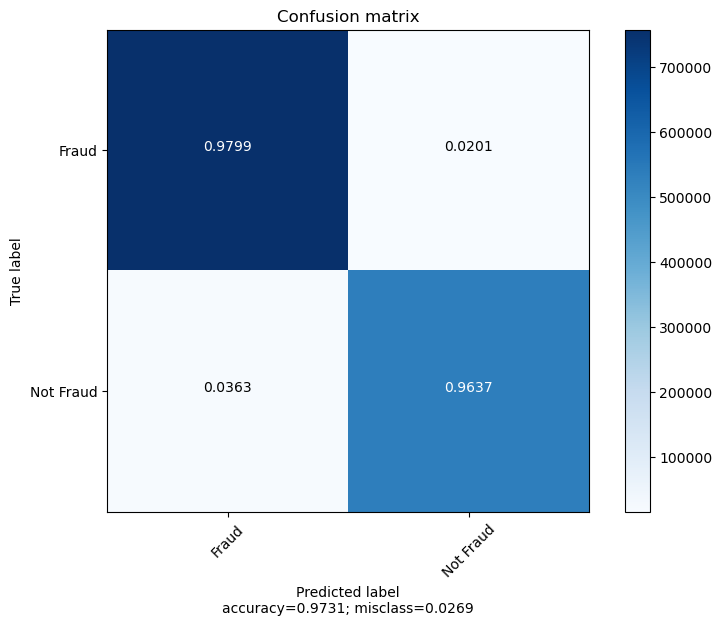

In [220]:
plot_confusion_matrix(confusion_matrix(Y_test,y_hat),["Fraud","Not Fraud"],normalize=True)

# KNN

In [137]:
# Downsampling majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,  # sample without replacement
                                   n_samples=len(df_minority),  # to match minority class
                                   random_state=42)  # reproducible results
df_majority_downsampled.shape



(15012, 22)

In [138]:
# Combining downsampled majority class with minority class
total_downsampled = pd.concat([df_majority_downsampled, df_minority])
total_downsampled.shape


(30024, 22)

In [139]:

# Splitting into training and testing sets
x_cols = list(total_downsampled.columns)
x_cols.remove('is_fraud')
X = total_downsampled[x_cols]
Y = total_downsampled['is_fraud']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [140]:
X_train.shape

(21016, 21)

In [141]:
from sklearn.neighbors import KNeighborsClassifier

In [142]:
#Setup arrays to store training and test accuracies
neighbors = np.arange(1,21)
# print(neighbors)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(X_train, Y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, Y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, Y_test) 
    
    

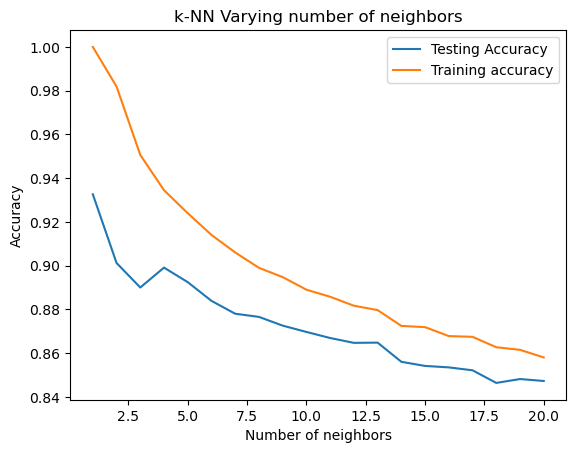

In [143]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [144]:
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(n_neighbors=1)
#Fit the model
knn.fit(X_train, Y_train)
#Get accuracy. Note: In case of classification algorithms score method represents accuracy.
knn.score(X_test,Y_test)

0.9326154529307282

In [145]:
#let us get the predictions using the classifier we had fit above
y_pred = knn.predict(X_test)

In [146]:
y_pred_proba = knn.predict_proba(X_test)[:,1]

In [147]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)

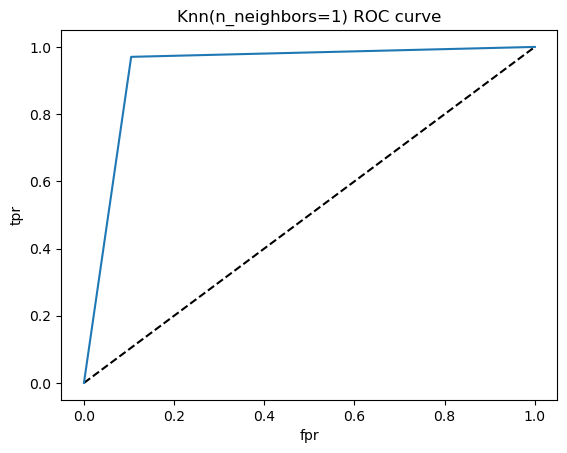

In [148]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=1) ROC curve')
plt.show()

In [149]:
#Area under ROC curve

roc_auc_score(Y_test,y_pred_proba)

0.9328743501065193

In [151]:
precision_score_ab =  precision_score(Y_test, y_pred)
accuracy_score_ab = accuracy_score(Y_test, y_pred)
print('The precision score is : ',round(precision_score_ab * 100,2), '%')
print('The accuracy score is : ',round(accuracy_score_ab * 100,2), '%')
print ('\nClassification Report TEST:\n', classification_report(Y_test,y_pred))

The precision score is :  90.14 %
The accuracy score is :  93.26 %

Classification Report TEST:
               precision    recall  f1-score   support

           0       0.97      0.90      0.93      4535
           1       0.90      0.97      0.93      4473

    accuracy                           0.93      9008
   macro avg       0.93      0.93      0.93      9008
weighted avg       0.94      0.93      0.93      9008



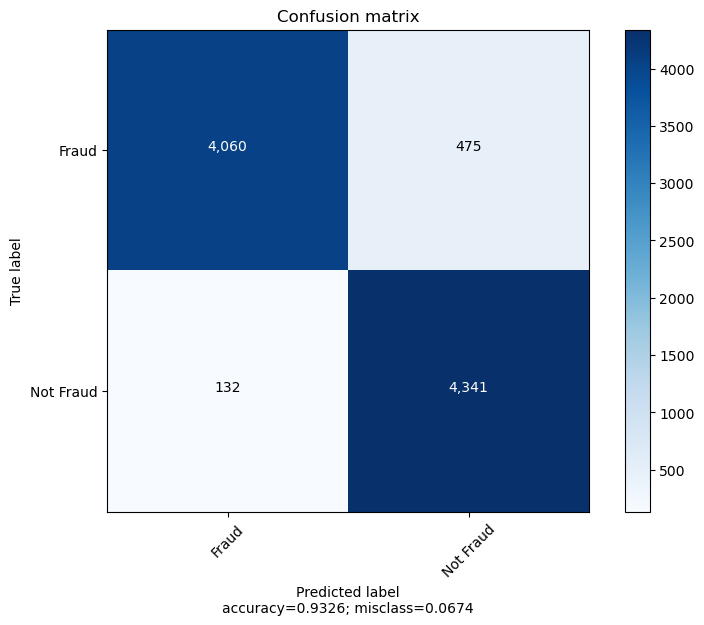

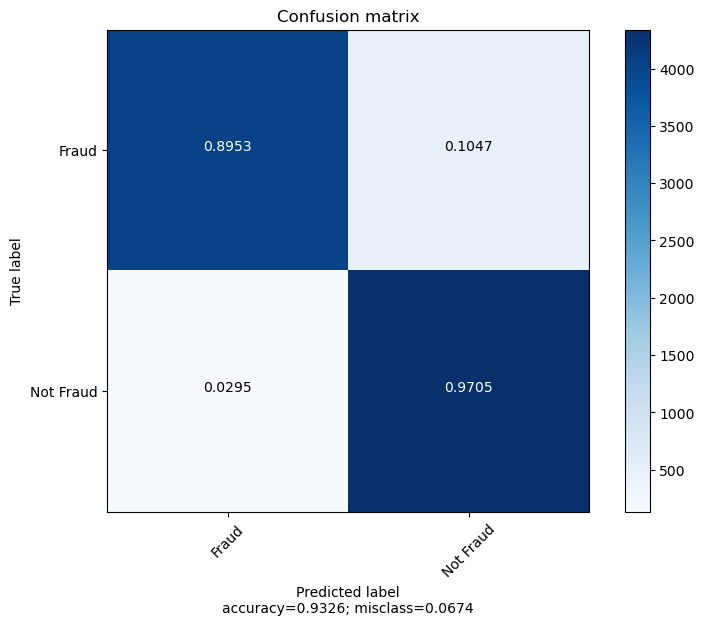

In [150]:
plot_confusion_matrix(confusion_matrix(Y_test,y_pred),["Fraud","Not Fraud"],normalize=False)
plot_confusion_matrix(confusion_matrix(Y_test,y_pred),["Fraud","Not Fraud"],normalize=True)

# XG Boost

In [65]:
from xgboost import XGBRegressor

In [66]:
xgb = XGBRegressor(n_estimators=500)
xgb.fit(X_train, Y_train, early_stopping_rounds=5,eval_set=[(X_test, Y_test)], verbose=False)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [72]:
Y_pred = xgb.predict(X_test)

In [73]:
Y_pred = [0 if i <=0.5 else 1 for i in Y_pred]


In [76]:
precision_score_ab =  precision_score(Y_test, Y_pred)
accuracy_score_ab = accuracy_score(Y_test, Y_pred)
print('The precision score is : ',round(precision_score_ab * 100,2), '%')
print('The accuracy score is : ',round(accuracy_score_ab * 100,2), '%')
print ('\nClassification Report TEST:\n', classification_report(Y_test,Y_pred))

The precision score is :  99.06 %
The accuracy score is :  99.6 %

Classification Report TEST:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    773252
           1       0.99      1.00      1.00    553073

    accuracy                           1.00   1326325
   macro avg       1.00      1.00      1.00   1326325
weighted avg       1.00      1.00      1.00   1326325



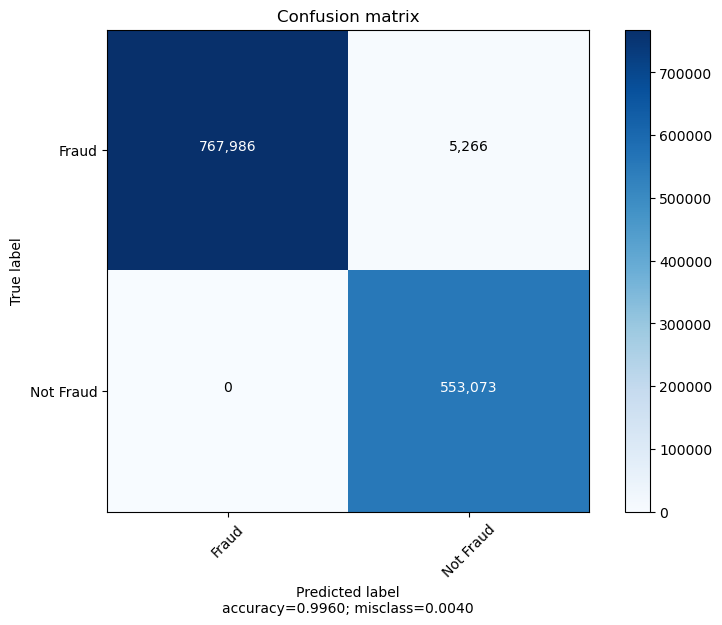

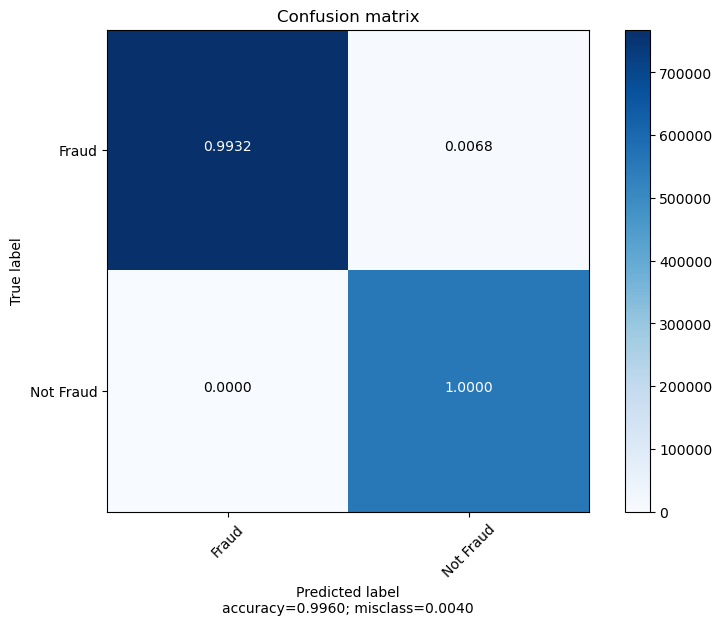

In [74]:
plot_confusion_matrix(confusion_matrix(Y_test,Y_pred),["Fraud","Not Fraud"],normalize=False)
plot_confusion_matrix(confusion_matrix(Y_test,Y_pred),["Fraud","Not Fraud"],normalize=True)

# Gradient Boost 

In [78]:
from sklearn.ensemble import GradientBoostingClassifier

In [79]:
gb = GradientBoostingClassifier( learning_rate = 0.11042628136263043, max_depth = None, max_leaf_nodes=30,min_samples_leaf=22)

In [80]:
gb.fit(X_train , Y_train)

GradientBoostingClassifier(learning_rate=0.11042628136263043, max_depth=None,
                           max_leaf_nodes=30, min_samples_leaf=22)

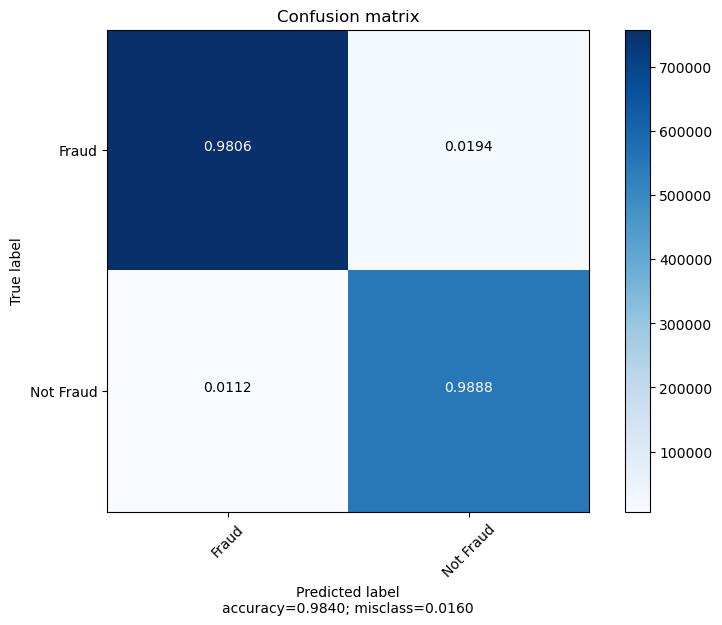

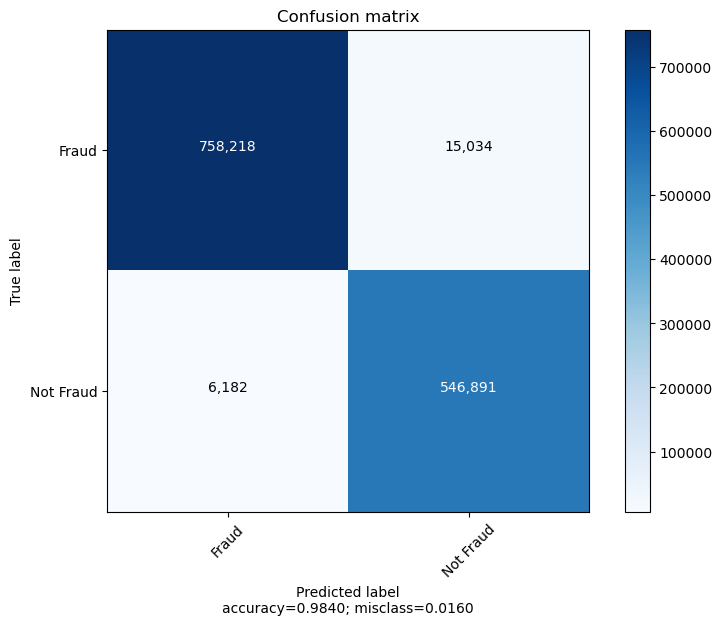

In [82]:
y_pred = gb.predict(X_test)

plot_confusion_matrix(confusion_matrix(Y_test,y_pred),["Fraud","Not Fraud"],normalize=True)
plot_confusion_matrix(confusion_matrix(Y_test,y_pred),["Fraud","Not Fraud"],normalize=False)

In [83]:
precision_score_ab =  precision_score(Y_test, y_pred)
accuracy_score_ab = accuracy_score(Y_test, y_pred)
print('The precision score is : ',round(precision_score_ab * 100,2), '%')
print('The accuracy score is : ',round(accuracy_score_ab * 100,2), '%')
print ('\nClassification Report TEST:\n', classification_report(Y_test,y_pred))

The precision score is :  97.32 %
The accuracy score is :  98.4 %

Classification Report TEST:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99    773252
           1       0.97      0.99      0.98    553073

    accuracy                           0.98   1326325
   macro avg       0.98      0.98      0.98   1326325
weighted avg       0.98      0.98      0.98   1326325



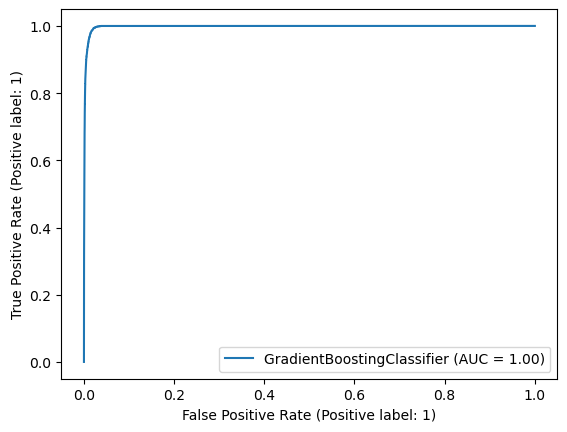

In [85]:
RocCurveDisplay.from_estimator(gb, X_test, Y_test)
plt.show()

# Neural Network

In [86]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense , Dropout , Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils.vis_utils import plot_model

In [125]:
model = Sequential()

In [126]:
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(16,activation="LeakyReLU",))
model.add(Dense(8,activation="relu",))
model.add(Dense(4,activation="LeakyReLU",))
model.add(Dense(2,activation="LeakyReLU",))
model.add(Dense(1,activation="sigmoid",))

In [127]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 16)                352       
                                                                 
 dense_46 (Dense)            (None, 8)                 136       
                                                                 
 dense_47 (Dense)            (None, 4)                 36        
                                                                 
 dense_48 (Dense)            (None, 2)                 10        
                                                                 
 dense_49 (Dense)            (None, 1)                 3         
                                                                 
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


In [128]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [129]:
history = model.fit(X_train, Y_train, epochs=25, batch_size=512,validation_split=0.2, shuffle= True)


Epoch 1/25
4836/4836 [==============================] - 15s 3ms/step - loss: 81.5722 - accuracy: 0.7809 - val_loss: 45.0525 - val_accuracy: 0.8029
Epoch 2/25
4836/4836 [==============================] - 14s 3ms/step - loss: 11.9437 - accuracy: 0.7998 - val_loss: 3.4757 - val_accuracy: 0.8522
Epoch 3/25
4836/4836 [==============================] - 13s 3ms/step - loss: 9.6891 - accuracy: 0.8174 - val_loss: 16.7463 - val_accuracy: 0.6964
Epoch 4/25
4836/4836 [==============================] - 13s 3ms/step - loss: 7.3619 - accuracy: 0.8329 - val_loss: 3.3017 - val_accuracy: 0.7868
Epoch 5/25
4836/4836 [==============================] - 14s 3ms/step - loss: 5.5365 - accuracy: 0.8454 - val_loss: 4.5446 - val_accuracy: 0.8671
Epoch 6/25
4836/4836 [==============================] - 13s 3ms/step - loss: 4.4303 - accuracy: 0.8542 - val_loss: 7.9104 - val_accuracy: 0.8696
Epoch 7/25
4836/4836 [==============================] - 14s 3ms/step - loss: 2.6779 - accuracy: 0.8593 - val_loss: 1.7997 - va

In [130]:
# Evaluate the model
y_pred = model.predict(X_test)
loss, accuracy = model.evaluate(X_test, Y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

41448/41448 [==============================] - 65s 2ms/step - loss: 0.2212 - accuracy: 0.9181
Test loss: 0.22123154997825623
Test accuracy: 0.9181090593338013


In [133]:
y_pred = [0 if i <=0.5 else 1 for i in Y_pred]

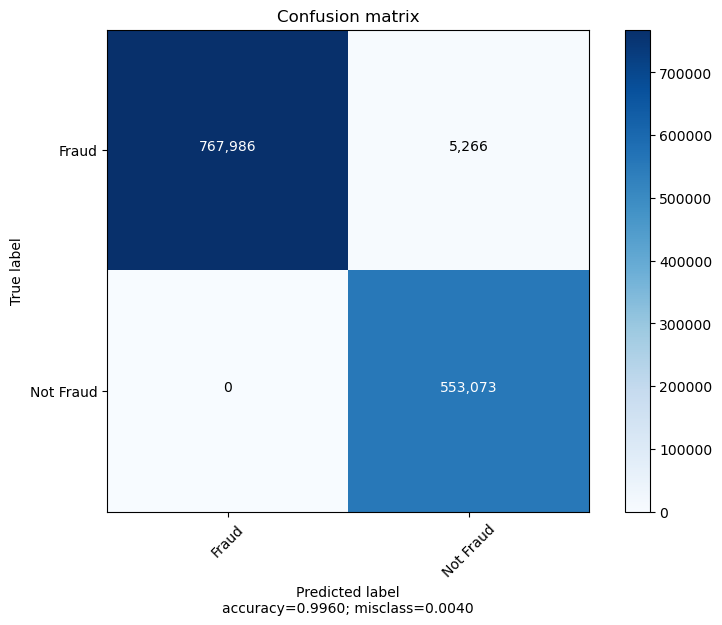

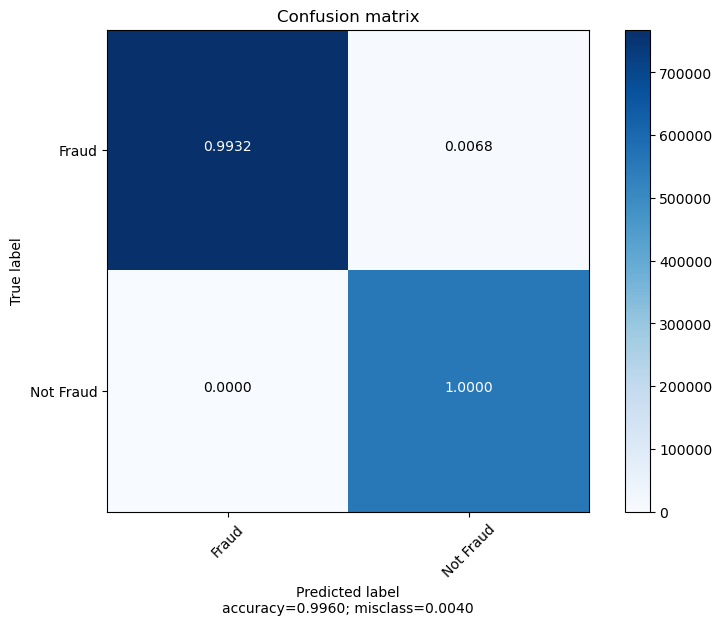

In [134]:
plot_confusion_matrix(confusion_matrix(Y_test,y_pred),["Fraud","Not Fraud"],normalize=False)
plot_confusion_matrix(confusion_matrix(Y_test,y_pred),["Fraud","Not Fraud"],normalize=True)

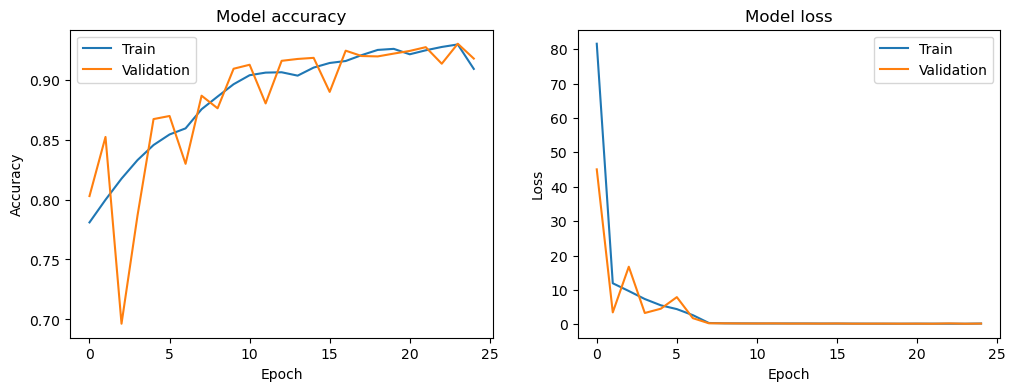

In [135]:
# Assuming history is the object returned by model.fit()
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.show()

plot_history(history)


In [2]:
accuracies = [86.66,86.59,99.97,99.74,99.97,97.31,93.26,99.60,98.40,91.81]
models = ["LogisticRegression" ,"Fine-tuned Logistic Regression","Decision Tree", "Hyperparameter Tuned Decision Tree","AdaBoost","Auto-sklearn","KNN","XGBoost","Gradient Boost","Neural Network"]

In [3]:
len(accuracies) == len(models)

True

In [4]:
mod_accuracies = pd.DataFrame({"Models":models,"Accuracies":accuracies})
mod_accuracies.sort_values(by="Accuracies",ascending=False)

,Models,Accuracies
2,Decision Tree,99.97
4,AdaBoost,99.97
3,Hyperparameter Tuned Decision Tree,99.74
7,XGBoost,99.60
8,Gradient Boost,98.40
5,Auto-sklearn,97.31
6,KNN,93.26
9,Neural Network,91.81
0,LogisticRegression,86.66
1,Fine-tuned Logistic Regression,86.59


/tmp/ipykernel_12292/538581203.py:26: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)


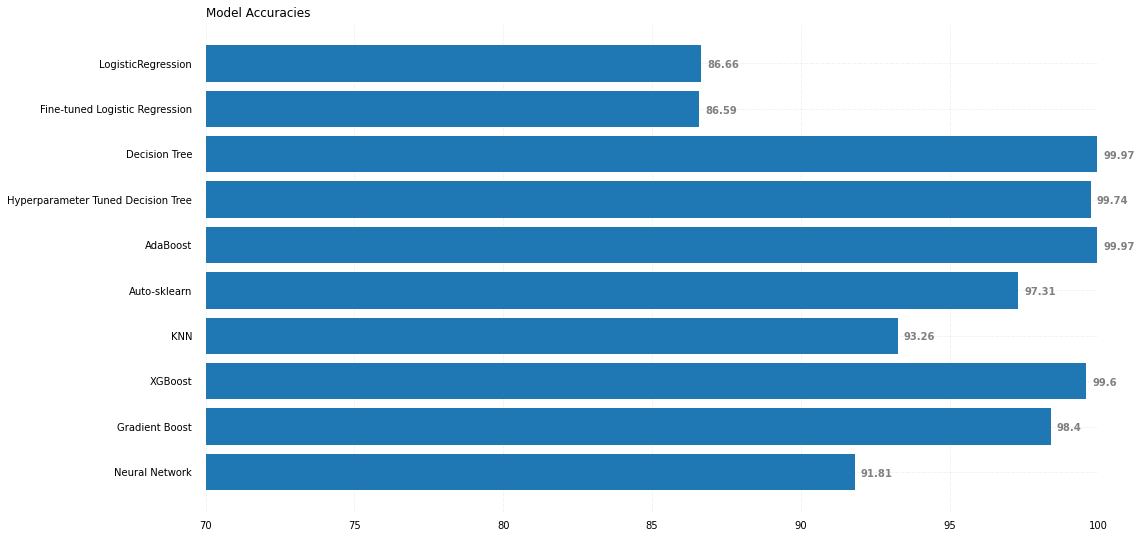

In [5]:


models = mod_accuracies['Models']
accuracies = mod_accuracies['Accuracies']

# Figure Size
fig, ax = plt.subplots(figsize=(16, 9))

# Horizontal Bar Plot
ax.barh(models, accuracies)

# Set x-axis range from 80% to 100%
plt.xlim(70, 100)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

# Add x, y gridlines
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width() + 0.2, i.get_y() + 0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Model Accuracies',
             loc='left')

# Show Plot
plt.show()
